Connect to global DB instead of local one (adjust path accordingly) and please export it locally 

In [1]:
import sys
import os

os.path.expanduser('~')
os.environ["FIFTYONE_CONFIG_PATH"] = os.path.expanduser('~') + "/.fiftyone/config.global_mongodb.json"
#os.environ["FIFTYONE_CONFIG_PATH"] = os.path.expanduser('~') + "/.fiftyone/app_config.json"


Check if you are using the correct database

In [2]:
from   fiftyone import ViewField as F
import fiftyone as fo
import numpy as np
import cv2

fo.list_datasets()

['HENSOLDT',
 'KEYMAKR_VIDEO_DATASET',
 'MV_SAILING_IMAGES_QA',
 'OCEANUS_SAILING_VIDEO_DATASET',
 'SAILING_DATASET',
 'SAILING_DATASET_QA',
 'SAILING_PANOPTIC_DATASET_QA',
 'SAILING_TO_AUTOMATIC_SEGMENT_DATASET',
 'SAM_TRACK_IMAGES',
 'SEGMENTATION_DATASET',
 'SENTRY_16BIT8BIT_DATASET',
 'SENTRY_IMAGES_SUBSAMPLE',
 'SENTRY_PANOPTIC_DATASET_QA',
 'SENTRY_SNAPSHOTS',
 'SENTRY_VIDEOS_DATASET_ALL',
 'SENTRY_VIDEOS_DATASET_QA',
 'TRAIN_PANOPTIC_DATASET',
 'TRAIN_PANOPTIC_DATASET_LOCAL',
 'TRAIN_PANOPTIC_OPTIMIZED_NAT',
 'TRAIN_RL_SPLIT_THERMAL_2023_11',
 'TRAIN_RL_SPLIT_THERMAL_2024_03',
 'TRAIN_THERMAL_DATASET_2023_06']

Load the 'MV_SAILING_IMAGES_QA' data

In [3]:

DATASET_NAME = "MV_SAILING_IMAGES_QA"
dataset = fo.load_dataset(DATASET_NAME)


Launch the APP

In [4]:
fo.launch_app(dataset,port=5150)

Dataset:         MV_SAILING_IMAGES_QA
Media type:      group
Num groups:      90651
Selected groups: 0
Selected labels: 0
Session URL:     http://localhost:5150/

Define useful functions 

In [6]:
def project_detection(line, homography, source_resolution,dst_resolution):

    width, height= source_resolution
    dst_width, dst_height= dst_resolution

    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[1][0]
    y2 = line[1][1]

    px1 = x1 * width
    py1 = y1 * height
    px2 = x2 * width
    py2 = y2 * height

    bbox = np.array([[[px1, py1], [(px2), (py2)]]])
    d = cv2.perspectiveTransform(bbox,homography)

    px1_proj = d[0][0][0]
    py1_proj = d[0][0][1]
    px2_proj = d[0][1][0]
    py2_proj = d[0][1][1]

    x1_proj = px1_proj / dst_width #/ metadata.width
    y1_proj = py1_proj / dst_height
    x2_proj =  px2_proj / dst_width
    y2_proj =  py2_proj / dst_height

    projected_line = np.array([[[x1_proj, y1_proj], [(x2_proj), (y2_proj)]]])

    return projected_line

In [23]:
import test_advanced_homography as hom_utils

def R_x(a): 
    ''' Get rotation matrix arround x. '''
    return np.array([[1, 0, 0], [0, np.cos(a), -np.sin(a)], [0, np.sin(a), np.cos(a)]])

def R_y(a):
    ''' Get rotation matrix arround y. '''
    return np.array([[np.cos(a), 0, np.sin(a)], [0, 1, 0], [-np.sin(a), 0, np.cos(a)]])

def R_z(a):
    ''' Get rotation matrix arround z. '''
    return np.array([[np.cos(a), -np.sin(a), 0], [np.sin(a), np.cos(a), 0], [0, 0, 1]])

def g2r(a):
    ''' Convert degree to radian. '''
    return a*np.pi/180

def prep_cal(cal:dict):
    '''
        Prepare calibration dictionary: convert lists to numpy arrays.
    '''
    for key in cal.keys():
        if type(cal[key]) == list:
            cal[key] = np.array(cal[key])
    return cal

def get_Knew(cal:dict):
    '''
        Get camera matrix for undistortion from calibration file. If not present, estimate it.
    '''
    if 'Knew' in cal:
        K = cal['Knew']
    else:
        cal = prep_cal(cal)
        K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
            K=cal['K'], 
            D=cal['D'], 
            image_size=(cal['resolution'][1], cal['resolution'][0]),
            R=np.eye(3),
            new_size=(cal['resolution'][1], cal['resolution'][0]),
            balance=0)
    return K

def get_calibration_homography(sensors_info):

    res_therm = sensors_info["thermal_camera_left"]["resolution"]
    roll_left = sensors_info["thermal_camera_left"]["psi_mc"]
    pitch_left = sensors_info["thermal_camera_left"]["theta_mc"]
    yaw_left = sensors_info["thermal_camera_left"]["phi_mc"]
    camera_matrix_left = sensors_info["thermal_camera_left"]["K"]
    fx_left = camera_matrix_left[0][0]
    fy_left = camera_matrix_left[1][1]

    roll_right = sensors_info["thermal_camera_right"]["psi_mc"]
    pitch_right = sensors_info["thermal_camera_right"]["theta_mc"]
    yaw_right = sensors_info["thermal_camera_right"]["phi_mc"]
    camera_matrix_right = sensors_info["thermal_camera_left"]["K"]
    fx_right = camera_matrix_right[0][0]
    fy_right = camera_matrix_right[1][1]

    res_rgb = sensors_info["rgb_camera"]["resolution"]
    roll_rgb = sensors_info["rgb_camera"]["psi_mc"]
    pitch_rgb = sensors_info["rgb_camera"]["theta_mc"]
    yaw_rgb = sensors_info["rgb_camera"]["phi_mc"]
    camera_matrix_rgb = sensors_info["rgb_camera"]["Knew"]
    fx_rgb = camera_matrix_rgb[0][0]
    fy_rgb = camera_matrix_rgb[1][1]


    R_l = hom_utils.rotation_matrix(np.deg2rad(roll_left),
                                    np.deg2rad(pitch_left),
                                    np.deg2rad(yaw_left),
                                    angle_conversion=False)
    R_r = hom_utils.rotation_matrix(np.deg2rad(roll_right),
                                    np.deg2rad(pitch_right),
                                    np.deg2rad(yaw_right),
                                    angle_conversion=False)
    R_rgb = hom_utils.rotation_matrix(np.deg2rad(roll_rgb),
                                    np.deg2rad(pitch_rgb), # -0,5
                                    np.deg2rad(yaw_rgb),
                                    angle_conversion=False)

    K_l = np.array([[-1*fx_left, 0, res_therm[1]/2],
                    [0, -1.*fy_left, res_therm[0]/2],
                    [0, 0, 1]])
    K_r = np.array([[-1.*fx_right, 0, res_therm[1]/2],
                    [0, -1.*fy_right, res_therm[0]/2],
                    [0, 0, 1]])


    K_rgb = np.array([[-fx_rgb, 0, res_rgb[1]/2],
                    [0, -fy_rgb, res_rgb[0]/2],
                    [0, 0, 1]])



    H_l_rgb = K_rgb @ np.linalg.inv(R_rgb) @ R_l @ np.linalg.inv(K_l)
    H_r_rgb = K_rgb @ np.linalg.inv(R_rgb) @ R_r @ np.linalg.inv(K_r)

    return H_l_rgb,H_r_rgb


In [59]:
import hom_utils
import sensors_api
import pickle
import matplotlib.patches as mpatches
import evaluate

from horizon_fusion import HorizonFusion as hf
from matplotlib import pyplot as plt
from itertools import zip_longest
from tqdm import tqdm

# Initialize sensor API
sens = sensors_api.SensorAPI('/home/hichem/Documents/Library/calibraion_data/')


In [56]:
# Method to fuse and normalize horizons
def fuse_and_normalize_horizons(left_horizon, right_horizon, rgb_horizon, width_rgb, height_rgb, horizon_weights):
    horizons_to_fuse = {
        "TlFoV": left_horizon,
        "TrFoV": right_horizon,
        "RGBFoV": rgb_horizon
    }

    fused_horizon = hf.fuse_offset_angle_horizons_with_weights(horizons_to_fuse, horizon_weights)
    fused_horizon_xyxy = hf.offset_angle_to_xyxy(fused_horizon, resolution=(width_rgb, height_rgb))
    fused_horizon_normalized = hf.normalize_horizon(fused_horizon_xyxy, resolution=(width_rgb, height_rgb))
    return fused_horizon_normalized , fused_horizon_xyxy


# Method to project and denormalize horizons
def project_horizon(horizon, H, width_src, height_src, width_dst, height_dst):
    denormalized_horizon = hf.denormalize_horizon(horizon, resolution=(width_src, height_src))
    oa_horizon = hf.xyxy_to_offset_angle(denormalized_horizon)
    horizon_in_dst = hf.project_offset_angle_horizon(oa_horizon, H, resolution=(width_src, height_src))
    #horizon_in_dst_xyxy = hf.offset_angle_to_xyxy(horizon, resolution = (width_dst,height_dst))

    return horizon_in_dst

## Overview

Run the statistics over all the database and check the metrics on the RGB image 

- Fusing horizons from all cameras
- Fusing horizons only from thermal cameras
- Comparing these to the performance on the reference image (Ground Truth, GT)
- Comparing individual horizon projection into RGB without fusion


In [37]:



dataset = fo.load_dataset(DATASET_NAME)
dataset = dataset.match(F("ground_truth_pl.polylines").exists())
#dataset = dataset.match(F("sequence").is_in(trip_sequences_list))

rgb_view = dataset.select_group_slices(["rgb"])
thermal_l_view = dataset.select_group_slices(["thermal_left"])
thermal_r_view = dataset.select_group_slices(["thermal_right"])

# Initialize lists
ground_truth_lines_rgb = []
ground_truth_lines_l = []
ground_truth_lines_r = []

prediction_lines_rgb = []
prediction_lines_l = []
prediction_lines_r = []

basic_lines_rgb_from_l = []
basic_lines_rgb_from_r = []

basic_lines_l_from_rgb = []
basic_lines_l_from_r = []

basic_lines_r_from_rgb = []
basic_lines_r_from_l = []

fused_horizon_thermal = []
fused_horizon_all = []

skipped = 0
processed = 0


for sample, sample_l, sample_r in tqdm(zip_longest(rgb_view, thermal_l_view, thermal_r_view), total=max(len(rgb_view), len(thermal_l_view), len(thermal_r_view)), desc="Processing samples"):

    width_rgb = sample.metadata.width
    height_rgb = sample.metadata.height

    width_t = sample_l.metadata.width
    height_t = sample_l.metadata.height

    try:

        prediction_lines_rgb.append(sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0])
        prediction_lines_l.append(sample_l["ahoy-IR-b2-whales"]["polylines"][0].points[0])
        prediction_lines_r.append(sample_r["ahoy-IR-b2-whales"]["polylines"][0].points[0])   

        ground_truth_lines_rgb.append(sample["ground_truth_pl"]["polylines"][0].points[0])
        ground_truth_lines_l.append(sample_l["ground_truth_pl"]["polylines"][0].points[0])
        ground_truth_lines_r.append(sample_r["ground_truth_pl"]["polylines"][0].points[0])

        sensors_info = sens.get_sensors_info(sample.sensorsData.UUID)
        H_l_rgb,H_r_rgb = get_calibration_homography(sensors_info)
        
        processed = processed + 1

    except:
        #print("skipped")
        skipped =  skipped + 1
        continue

    # for RGB
    line_on_rgb_from_l_basic = project_detection(sample_l["ahoy-IR-b2-whales"]["polylines"][0].points[0], H_l_rgb, (width_t,height_t)  ,(width_rgb,height_rgb))
    line_on_rgb_from_r_basic = project_detection(sample_r["ahoy-IR-b2-whales"]["polylines"][0].points[0], H_r_rgb, (width_t,height_t)  ,(width_rgb,height_rgb))

    basic_lines_rgb_from_l.append([ [line_on_rgb_from_l_basic[0][0][0],line_on_rgb_from_l_basic[0][0][1]] , [line_on_rgb_from_l_basic[0][1][0],line_on_rgb_from_l_basic[0][1][1]] ])
    basic_lines_rgb_from_r.append([ [line_on_rgb_from_r_basic[0][0][0],line_on_rgb_from_r_basic[0][0][1]] , [line_on_rgb_from_r_basic[0][1][0],line_on_rgb_from_r_basic[0][1][1]] ])

    # for Thermal left
    line_on_l_from_rgb_basic = project_detection(sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0], np.linalg.inv(H_l_rgb), (width_rgb,height_rgb)  ,(width_t,height_t))
    line_on_l_from_r_basic = project_detection(sample_r["ahoy-IR-b2-whales"]["polylines"][0].points[0], np.linalg.inv(H_l_rgb)*H_r_rgb, (width_t,height_t)  ,(width_t,height_t))

    basic_lines_l_from_rgb.append([ [line_on_l_from_rgb_basic[0][0][0],line_on_l_from_rgb_basic[0][0][1]] , [line_on_l_from_rgb_basic[0][1][0],line_on_l_from_rgb_basic[0][1][1]] ])
    basic_lines_l_from_r.append([ [line_on_l_from_r_basic[0][0][0],line_on_l_from_r_basic[0][0][1]] , [line_on_l_from_r_basic[0][1][0],line_on_l_from_r_basic[0][1][1]] ])

    ## for Thermal right
    line_on_r_from_rgb_basic = project_detection(sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0], np.linalg.inv(H_r_rgb), (width_rgb,height_rgb)  ,(width_t,height_t))
    line_on_r_from_l_basic = project_detection(sample_l["ahoy-IR-b2-whales"]["polylines"][0].points[0], np.linalg.inv(H_r_rgb)*H_l_rgb, (width_t,height_t)  ,(width_t,height_t))

    basic_lines_r_from_rgb.append([ [line_on_r_from_rgb_basic[0][0][0],line_on_r_from_rgb_basic[0][0][1]] , [line_on_r_from_rgb_basic[0][1][0],line_on_r_from_rgb_basic[0][1][1]] ])
    basic_lines_r_from_l.append([ [line_on_r_from_l_basic[0][0][0],line_on_r_from_l_basic[0][0][1]] , [line_on_r_from_l_basic[0][1][0],line_on_r_from_l_basic[0][1][1]] ])

    #Left Horizon
    left_horizon = sample_l["ahoy-IR-b2-whales"]["polylines"][0].points[0]
    left_horizon_in_rgb = project_horizon(left_horizon, H_l_rgb, width_t, height_t, width_rgb, height_rgb)

    #Right Horizon
    left_horizon = sample_r["ahoy-IR-b2-whales"]["polylines"][0].points[0]
    right_horizon_in_rgb = project_horizon(left_horizon, H_r_rgb, width_t, height_t, width_rgb, height_rgb)

    #RGB Horizon
    rgb_horizon = sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0]
    rgb_horizon_denormalized = hf.denormalize_horizon(rgb_horizon, resolution=(width_rgb,height_rgb))
    rgb_horizon_oa = hf.xyxy_to_offset_angle(rgb_horizon_denormalized)

    # Fuse only thermal cameras
    horizon_weights = {"TlFoV": 1, "TrFoV": 1, "RGBFoV": 0} 
    fused_horizon_normalized, _ = fuse_and_normalize_horizons(left_horizon_in_rgb, right_horizon_in_rgb, rgb_horizon_oa, width_rgb, height_rgb, horizon_weights)
    fused_horizon_thermal.append(fused_horizon_normalized)

    # Fuse All Horizons
    horizon_weights = {"TlFoV": 1, "TrFoV": 1, "RGBFoV": 1}  
    fused_horizon_normalized, _ = fuse_and_normalize_horizons(left_horizon_in_rgb, right_horizon_in_rgb, rgb_horizon_oa, width_rgb, height_rgb, horizon_weights)
    fused_horizon_all.append(fused_horizon_normalized)



Processing samples: 100%|██████████| 22291/22291 [03:10<00:00, 116.71it/s]


Run the metrics for the collected inputs

In [38]:


module = evaluate.load("SEA-AI/horizon-metrics", roll_threshold=0.5, pitch_threshold=0.1, vertical_fov_degrees=25.6,height=height_rgb)
module.add(predictions= prediction_lines_rgb, references= ground_truth_lines_rgb )
output_rgb_default = module.compute()
print(output_rgb_default)

module = evaluate.load("SEA-AI/horizon-metrics", roll_threshold=0.5, pitch_threshold=0.1, vertical_fov_degrees=25.6,height=height_rgb)
module.add(predictions=fused_horizon_all , references=ground_truth_lines_rgb)
output_rgb_basic_all = module.compute()
print(output_rgb_basic_all)

module = evaluate.load("SEA-AI/horizon-metrics", roll_threshold=0.5, pitch_threshold=0.1, vertical_fov_degrees=25.6,height=height_rgb)
module.add(predictions=fused_horizon_thermal , references=ground_truth_lines_rgb)
output_rgb_basic_thermal = module.compute()
print(output_rgb_basic_thermal)

module = evaluate.load("SEA-AI/horizon-metrics", roll_threshold=0.5, pitch_threshold=0.1, vertical_fov_degrees=25.6,height=height_rgb)
module.add(predictions=basic_lines_rgb_from_l , references=ground_truth_lines_rgb)
output_rgb_basic_l = module.compute()
print(output_rgb_basic_l)

module = evaluate.load("SEA-AI/horizon-metrics", roll_threshold=0.5, pitch_threshold=0.1, vertical_fov_degrees=25.6,height=height_rgb)
module.add(predictions=basic_lines_rgb_from_r , references=ground_truth_lines_rgb)
output_rgb_basic_r = module.compute()
print(output_rgb_basic_r)



{'average_slope_error': 3.1667814687646643, 'average_midpoint_error': 2.145217010123662, 'average_midpoint_error_px': 90.50134261459199, 'stddev_slope_error': 3.079850700131413, 'stddev_midpoint_error': 2.9802924943777644, 'stddev_midpoint_error_px': 125.73108960656194, 'max_slope_error': 20.99868157771517, 'max_midpoint_error': 9.683775661375664, 'max_midpoint_error_px': 408.53428571428583, 'num_slope_error_jumps': 947, 'num_midpoint_error_jumps': 860, 'detection_rate': 1.2496723460026213}
{'average_slope_error': 1.4312093274423883, 'average_midpoint_error': 0.3828035701239412, 'average_midpoint_error_px': 16.149525614603768, 'stddev_slope_error': 0.7719674490846866, 'stddev_midpoint_error': 0.6331734073740881, 'stddev_midpoint_error_px': 26.712003123594343, 'max_slope_error': 4.89025604421243, 'max_midpoint_error': 2.7234664528061003, 'max_midpoint_error_px': 114.89624097775736, 'num_slope_error_jumps': 276, 'num_midpoint_error_jumps': 235, 'detection_rate': 1.0}
{'average_slope_erro

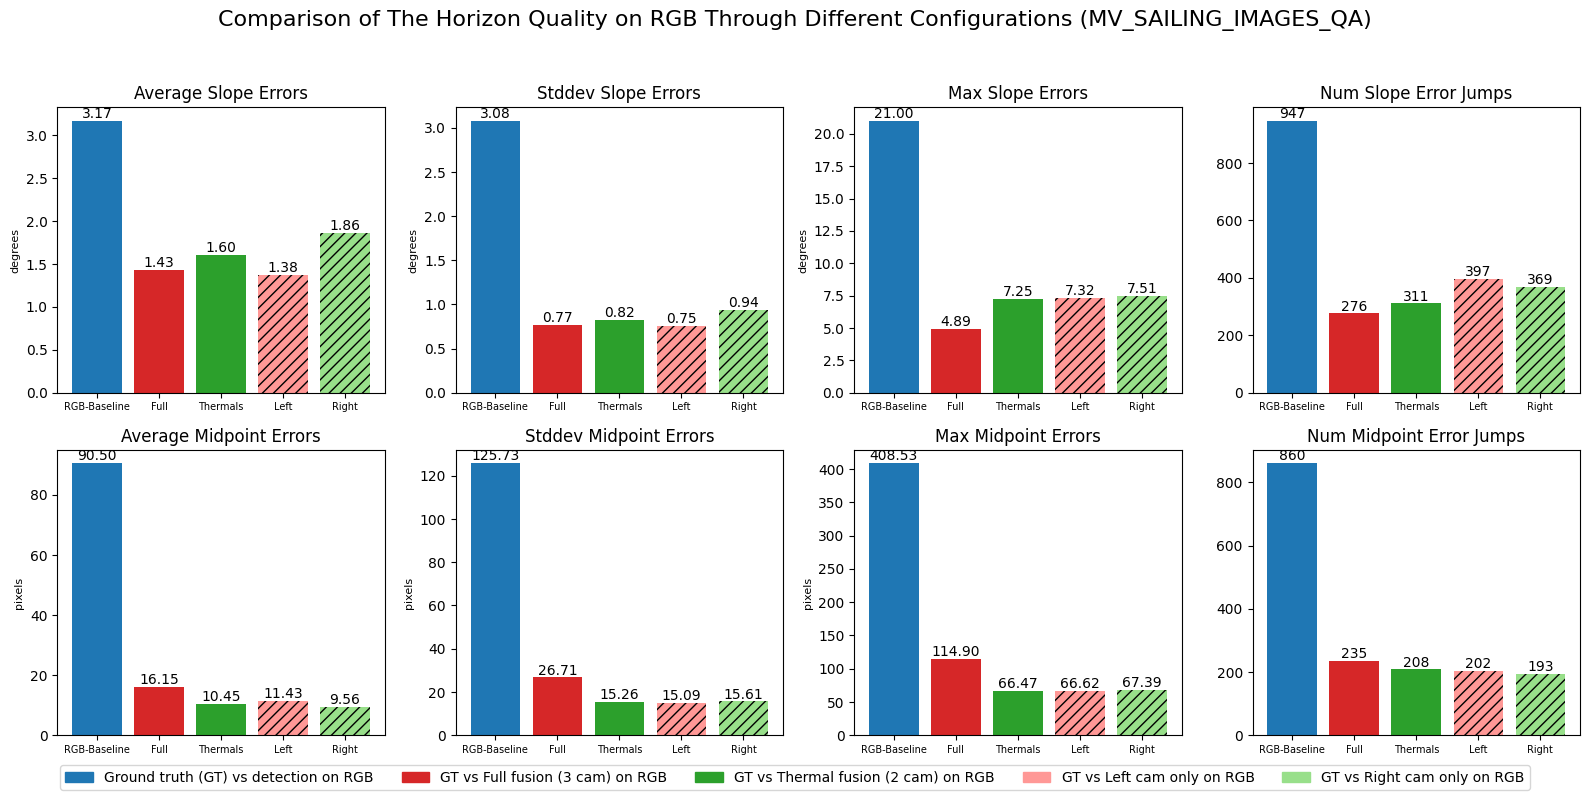

In [39]:

output_rgb = output_rgb_default
basic_l = output_rgb_basic_all
basic_r = output_rgb_basic_thermal
output_l = output_rgb_basic_l
output_r = output_rgb_basic_r

categories = ['RGB-Baseline', 'Full', 'Thermals', 'Left', 'Right']

average_slope_errors = [output_rgb["average_slope_error"], basic_l["average_slope_error"], basic_r["average_slope_error"], output_l["average_slope_error"], output_r["average_slope_error"]]
stddev_slope_errors = [output_rgb["stddev_slope_error"], basic_l["stddev_slope_error"], basic_r["stddev_slope_error"], output_l["stddev_slope_error"], output_r["stddev_slope_error"]]
max_slope_errors = [output_rgb["max_slope_error"], basic_l["max_slope_error"], basic_r["max_slope_error"], output_l["max_slope_error"], output_r["max_slope_error"]]
num_slope_error_jumps = [output_rgb["num_slope_error_jumps"], basic_l["num_slope_error_jumps"], basic_r["num_slope_error_jumps"], output_l["num_slope_error_jumps"], output_r["num_slope_error_jumps"]]

average_midpoint_errors = [output_rgb["average_midpoint_error_px"], basic_l["average_midpoint_error_px"], basic_r["average_midpoint_error_px"], output_l["average_midpoint_error_px"], output_r["average_midpoint_error_px"]]
stddev_midpoint_errors = [output_rgb["stddev_midpoint_error_px"], basic_l["stddev_midpoint_error_px"], basic_r["stddev_midpoint_error_px"], output_l["stddev_midpoint_error_px"], output_r["stddev_midpoint_error_px"]]
max_midpoint_errors = [output_rgb["max_midpoint_error_px"], basic_l["max_midpoint_error_px"], basic_r["max_midpoint_error_px"], output_l["max_midpoint_error_px"], output_r["max_midpoint_error_px"]]
num_midpoint_error_jumps = [output_rgb["num_midpoint_error_jumps"], basic_l["num_midpoint_error_jumps"], basic_r["num_midpoint_error_jumps"], output_l["num_midpoint_error_jumps"], output_r["num_midpoint_error_jumps"]]

colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff9896', '#98df8a']
hatches = ['', '', '', '///', '///']

# Plotting
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

# Plot Average Slope Errors
bars = ax[0, 0].bar(categories, average_slope_errors, color=colors, hatch=hatches)
ax[0, 0].set_title('Average Slope Errors')
ax[0, 0].set_ylabel('degrees', fontsize=8)
ax[0, 0].bar_label(bars, fmt='%.2f')

# Plot Stddev Slope Errors
bars = ax[0, 1].bar(categories, stddev_slope_errors, color=colors, hatch=hatches)
ax[0, 1].set_title('Stddev Slope Errors')
ax[0, 1].set_ylabel('degrees', fontsize=8)
ax[0, 1].bar_label(bars, fmt='%.2f')

# Plot Max Slope Errors
bars = ax[0, 2].bar(categories, max_slope_errors, color=colors, hatch=hatches)
ax[0, 2].set_title('Max Slope Errors')
ax[0, 2].set_ylabel('degrees', fontsize=8)
ax[0, 2].bar_label(bars, fmt='%.2f')

# Plot Num Slope Error Jumps
bars = ax[0, 3].bar(categories, num_slope_error_jumps, color=colors, hatch=hatches)
ax[0, 3].set_title('Num Slope Error Jumps')
ax[0, 3].set_ylabel(' ', fontsize=8)
ax[0, 3].bar_label(bars, fmt='%d')

# Plot Average Midpoint Errors
bars = ax[1, 0].bar(categories, average_midpoint_errors, color=colors, hatch=hatches)
ax[1, 0].set_title('Average Midpoint Errors')
ax[1, 0].set_ylabel('pixels', fontsize=8)
ax[1, 0].bar_label(bars, fmt='%.2f')

# Plot Stddev Midpoint Errors
bars = ax[1, 1].bar(categories, stddev_midpoint_errors, color=colors, hatch=hatches)
ax[1, 1].set_title('Stddev Midpoint Errors')
ax[1, 1].set_ylabel('pixels', fontsize=8)
ax[1, 1].bar_label(bars, fmt='%.2f')

# Plot Max Midpoint Errors
bars = ax[1, 2].bar(categories, max_midpoint_errors, color=colors, hatch=hatches)
ax[1, 2].set_title('Max Midpoint Errors')
ax[1, 2].set_ylabel('pixels', fontsize=8)
ax[1, 2].bar_label(bars, fmt='%.2f')

# Plot Num Midpoint Error Jumps
bars = ax[1, 3].bar(categories, num_midpoint_error_jumps, color=colors, hatch=hatches)
ax[1, 3].set_title('Num Midpoint Error Jumps')
ax[1, 3].set_ylabel(' ', fontsize=8)
ax[1, 3].bar_label(bars, fmt='%d')

for axes in ax.flat:
    axes.tick_params(axis='x', labelsize=7)  # Adjust x-axis label font size

# Add global title
fig.suptitle('Comparison of The Horizon Quality on RGB Through Different Configurations (MV_SAILING_IMAGES_QA)', fontsize=16)

# Add legend at the bottom
# Create legend handles
descriptions = ['Ground truth (GT) vs detection on RGB', 'GT vs Full fusion (3 cam) on RGB', 'GT vs Thermal fusion (2 cam) on RGB', 'GT vs Left cam only on RGB', 'GT vs Right cam only on RGB']

legend_handles = [mpatches.Patch(color=colors[i], label=descriptions[i]) for i in range(len(descriptions))]

# Add legend at the bottom
fig.legend(handles=legend_handles, loc='lower center', ncol=len(descriptions), fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the global title and legend
#plt.savefig('rgb_stats_fusion_1526.png', dpi=300, bbox_inches='tight')
plt.show()


Run the metric statistics on each of the sequence to have a better understanding 

In [60]:

# Get unique sequences
dataset = fo.load_dataset(DATASET_NAME)
dataset = dataset.match(F("ground_truth_pl.polylines").exists())
sequences = set(dataset.values("sequence"))

trip_sequences_list = ['Trip_283_Seq_11', 'Trip_284_Seq_173', 'Trip_306_Seq_12', 'Trip_306_Seq_9', 'Trip_334_Seq_21', 'Trip_334_Seq_27', 'Trip_283_Seq_8', 'Trip_304_Seq_44', 'Trip_306_Seq_18', 'Trip_334_Seq_13', 'Trip_334_Seq_24', 'Trip_356_Seq_8', 'Trip_284_Seq_171', 'Trip_306_Seq_10', 'Trip_306_Seq_8', 'Trip_334_Seq_19', 'Trip_334_Seq_25']

# Define function to save results as pickle file
def save_results(sequence_name, results):
    filename = f"{sequence_name}_results.pkl"
    with open('./stats/'+filename, 'wb') as f:
        pickle.dump(results, f)

for sequence in trip_sequences_list:

#sequence = "Trip_306_Seq_10"
    print(f"Processing sequence: {sequence}")

    dataset = fo.load_dataset(DATASET_NAME)
    dataset = dataset.match(F("ground_truth_pl.polylines").exists())
    dataset = dataset.match(F("sequence") == sequence)

    rgb_view = dataset.select_group_slices(["rgb"])
    thermal_l_view = dataset.select_group_slices(["thermal_left"])
    thermal_r_view = dataset.select_group_slices(["thermal_right"])

    ground_truth_lines_rgb  = []
    ground_truth_lines_l  = []
    ground_truth_lines_r  = []

    prediction_lines_rgb  = []
    prediction_lines_l  = []
    prediction_lines_r = [] 

    basic_lines_rgb_from_l  = []
    basic_lines_rgb_from_r  = []

    basic_lines_l_from_rgb  = []
    basic_lines_l_from_r  = []
    basic_lines_r_from_rgb  = []
    basic_lines_r_from_l  = []

    fused_horizon_thermal  = []
    fused_horizon_all  = []

    draw_first_img = False

    skipped = 0
    processed = 0

    for sample, sample_l, sample_r in tqdm(zip_longest(rgb_view, thermal_l_view, thermal_r_view), total=max(len(rgb_view), len(thermal_l_view), len(thermal_r_view)), desc="Processing samples"):


        if draw_first_img:
            rgb_image = cv2.imread(sample.filepath)
            l_image = cv2.imread(sample_l.filepath)
            r_image = cv2.imread(sample_r.filepath)

        width_rgb = sample.metadata.width
        height_rgb = sample.metadata.height

        width_t = sample_l.metadata.width
        height_t = sample_l.metadata.height

        try:

            prediction_lines_rgb.append(sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0])
            prediction_lines_l.append(sample_l["ahoy-IR-b2-whales"]["polylines"][0].points[0])
            prediction_lines_r.append(sample_r["ahoy-IR-b2-whales"]["polylines"][0].points[0])   

            ground_truth_lines_rgb.append(sample["ground_truth_pl"]["polylines"][0].points[0])
            ground_truth_lines_l.append(sample_l["ground_truth_pl"]["polylines"][0].points[0])
            ground_truth_lines_r.append(sample_r["ground_truth_pl"]["polylines"][0].points[0])

            sensors_info = sens.get_sensors_info(sample.sensorsData.UUID)
            H_l_rgb,H_r_rgb = get_calibration_homography(sensors_info)

            processed = processed + 1

        except:
            #print("skipped")
            skipped =  skipped + 1
            continue


        # for RGB
        line_on_rgb_from_l_basic = project_detection(sample_l["ahoy-IR-b2-whales"]["polylines"][0].points[0], H_l_rgb, (width_t,height_t)  ,(width_rgb,height_rgb))
        line_on_rgb_from_r_basic = project_detection(sample_r["ahoy-IR-b2-whales"]["polylines"][0].points[0], H_r_rgb, (width_t,height_t)  ,(width_rgb,height_rgb))

        basic_lines_rgb_from_l.append([ [line_on_rgb_from_l_basic[0][0][0],line_on_rgb_from_l_basic[0][0][1]] , [line_on_rgb_from_l_basic[0][1][0],line_on_rgb_from_l_basic[0][1][1]] ])
        basic_lines_rgb_from_r.append([ [line_on_rgb_from_r_basic[0][0][0],line_on_rgb_from_r_basic[0][0][1]] , [line_on_rgb_from_r_basic[0][1][0],line_on_rgb_from_r_basic[0][1][1]] ])

        # for Thermal left
        line_on_l_from_rgb_basic = project_detection(sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0], np.linalg.inv(H_l_rgb), (width_rgb,height_rgb)  ,(width_t,height_t))
        line_on_l_from_r_basic = project_detection(sample_r["ahoy-IR-b2-whales"]["polylines"][0].points[0], np.linalg.inv(H_l_rgb)*H_r_rgb, (width_t,height_t)  ,(width_t,height_t))

        basic_lines_l_from_rgb.append([ [line_on_l_from_rgb_basic[0][0][0],line_on_l_from_rgb_basic[0][0][1]] , [line_on_l_from_rgb_basic[0][1][0],line_on_l_from_rgb_basic[0][1][1]] ])
        basic_lines_l_from_r.append([ [line_on_l_from_r_basic[0][0][0],line_on_l_from_r_basic[0][0][1]] , [line_on_l_from_r_basic[0][1][0],line_on_l_from_r_basic[0][1][1]] ])

        ## for Thermal right
        line_on_r_from_rgb_basic = project_detection(sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0], np.linalg.inv(H_r_rgb), (width_rgb,height_rgb)  ,(width_t,height_t))
        line_on_r_from_l_basic = project_detection(sample_l["ahoy-IR-b2-whales"]["polylines"][0].points[0], np.linalg.inv(H_r_rgb)*H_l_rgb, (width_t,height_t)  ,(width_t,height_t))

        basic_lines_r_from_rgb.append([ [line_on_r_from_rgb_basic[0][0][0],line_on_r_from_rgb_basic[0][0][1]] , [line_on_r_from_rgb_basic[0][1][0],line_on_r_from_rgb_basic[0][1][1]] ])
        basic_lines_r_from_l.append([ [line_on_r_from_l_basic[0][0][0],line_on_r_from_l_basic[0][0][1]] , [line_on_r_from_l_basic[0][1][0],line_on_r_from_l_basic[0][1][1]] ])
        
        #Left Horizon
        left_horizon = sample_l["ahoy-IR-b2-whales"]["polylines"][0].points[0]
        left_horizon_in_rgb = project_horizon(left_horizon, H_l_rgb, width_t, height_t, width_rgb, height_rgb)

        #Right Horizon
        left_horizon = sample_r["ahoy-IR-b2-whales"]["polylines"][0].points[0]
        right_horizon_in_rgb = project_horizon(left_horizon, H_r_rgb, width_t, height_t, width_rgb, height_rgb)

        # RGB Horizon
        rgb_horizon = sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0]
        rgb_horizon_denormalized = hf.denormalize_horizon(rgb_horizon, resolution=(width_rgb, height_rgb))
        rgb_horizon_oa = hf.xyxy_to_offset_angle(rgb_horizon_denormalized)

        # Fuse only thermal cameras
        horizon_weights = {"TlFoV": 1, "TrFoV": 1, "RGBFoV": 0} 
        fused_horizon_normalized, fused_horizon_xyxy = fuse_and_normalize_horizons(left_horizon_in_rgb, right_horizon_in_rgb, rgb_horizon_oa, width_rgb, height_rgb, horizon_weights)
        fused_horizon_thermal.append(fused_horizon_normalized)

        # Fuse All Horizons
        horizon_weights = {"TlFoV": 1, "TrFoV": 1, "RGBFoV": 1}  
        fused_horizon_normalized_all, fused_horizon_xyxy_all = fuse_and_normalize_horizons(left_horizon_in_rgb, right_horizon_in_rgb, rgb_horizon_oa, width_rgb, height_rgb, horizon_weights)
        fused_horizon_all.append(fused_horizon_normalized_all)

        if draw_first_img:

            line_rgb_gt = [
                sample["ground_truth_pl"]["polylines"][0].points[0][0][0] * width_rgb,  # xmin
                sample["ground_truth_pl"]["polylines"][0].points[0][0][1] * height_rgb, # ymin
                sample["ground_truth_pl"]["polylines"][0].points[0][1][0] * width_rgb,  # xmax
                sample["ground_truth_pl"]["polylines"][0].points[0][1][1] * height_rgb  # ymax
            ]

            line_rgb_pred = [
                sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0][0][0] * width_rgb,  # xmin
                sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0][0][1] * height_rgb, # ymin
                sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0][1][0] * width_rgb,  # xmax
                sample["ahoy-RGB-b2_pl"]["polylines"][0].points[0][1][1] * height_rgb  # ymax
            ]

            line_rgb_from_l_basic = [
                line_on_rgb_from_l_basic[0][0][0] * width_rgb,  # xmin
                line_on_rgb_from_l_basic[0][0][1] * height_rgb,  # xmin
                line_on_rgb_from_l_basic[0][1][0] * width_rgb,  # xmin
                line_on_rgb_from_l_basic[0][1][1] * height_rgb,  # xmin
            ]

            line_rgb_from_r_basic = [
                line_on_rgb_from_r_basic[0][0][0] * width_rgb,  # xmin
                line_on_rgb_from_r_basic[0][0][1] * height_rgb,  # xmin
                line_on_rgb_from_r_basic[0][1][0] * width_rgb,  # xmin
                line_on_rgb_from_r_basic[0][1][1] * height_rgb,  # xmin
            ]


            plt.figure(0)
            plt.imshow(rgb_image)
            plt.plot([line_rgb_gt[0], line_rgb_gt[2]], [line_rgb_gt[1], line_rgb_gt[3]], color='#00FF00', linestyle='--', label='Ground Truth', linewidth=0.5)  # Bright Red
            plt.plot([line_rgb_pred[0], line_rgb_pred[2]], [line_rgb_pred[1], line_rgb_pred[3]], color='#FF0000', linestyle='--', label='Prediction', linewidth=0.5)  # Bright Green
            plt.plot([line_rgb_from_l_basic[0], line_rgb_from_l_basic[2]], [line_rgb_from_l_basic[1], line_rgb_from_l_basic[3]], color='#0000FF', linestyle='--', label='Projected L', linewidth=1)  # Bright Blue
            plt.plot([line_rgb_from_r_basic[0], line_rgb_from_r_basic[2]], [line_rgb_from_r_basic[1], line_rgb_from_r_basic[3]], color='#FF00FF', linestyle='--', label='Projected R', linewidth=1)  # Magenta
            plt.plot([int(fused_horizon_xyxy[0][0]), int(fused_horizon_xyxy[1][0])], [int(fused_horizon_xyxy[0][1]), int(fused_horizon_xyxy[1][1])], color='#FFFF00', linestyle='--', label='Fused 2t', linewidth=1)  # Yellow
            plt.plot([int(fused_horizon_xyxy_all[0][0]), int(fused_horizon_xyxy_all[1][0])], [int(fused_horizon_xyxy_all[0][1]), int(fused_horizon_xyxy_all[1][1])], color='#00FFFF', linestyle='--', label='Fused all', linewidth=1)  # Cyan

            plt.legend()  # Add legend to the plot
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the global title and legend
            plt.savefig('./visual/' + 'img_' + sequence + '_' + sample.id + '.png', dpi=300, bbox_inches='tight')
            plt.close()  # Close the figure to free up memory
            draw_first_img = False


    # Evaluate results
    results = {}
    if len(fused_horizon_all)>0 and len(prediction_lines_rgb)>0 and len(ground_truth_lines_rgb)>0:

        module = evaluate.load("SEA-AI/horizon-metrics", roll_threshold=0.5, pitch_threshold=0.1, vertical_fov_degrees=25.6,height=height_rgb)
        module.add(predictions= prediction_lines_rgb, references= ground_truth_lines_rgb )
        output_rgb_default = module.compute()
        results['output_rgb_default'] = output_rgb_default

        module = evaluate.load("SEA-AI/horizon-metrics", roll_threshold=0.5, pitch_threshold=0.1, vertical_fov_degrees=25.6,height=height_rgb)
        module.add(predictions=fused_horizon_all , references=ground_truth_lines_rgb)
        fused_horizon_all = module.compute()
        results['fused_horizon_all'] = fused_horizon_all

        module = evaluate.load("SEA-AI/horizon-metrics", roll_threshold=0.5, pitch_threshold=0.1, vertical_fov_degrees=25.6,height=height_rgb)
        module.add(predictions=fused_horizon_thermal , references=ground_truth_lines_rgb)
        fused_horizon_thermal = module.compute()
        results['fused_horizon_thermal'] = fused_horizon_thermal

        module = evaluate.load("SEA-AI/horizon-metrics", roll_threshold=0.5, pitch_threshold=0.1, vertical_fov_degrees=25.6,height=height_rgb)
        module.add(predictions=basic_lines_rgb_from_l , references=ground_truth_lines_rgb)
        output_rgb_basic_l = module.compute()
        results['output_rgb_basic_l'] = output_rgb_basic_l

        module = evaluate.load("SEA-AI/horizon-metrics", roll_threshold=0.5, pitch_threshold=0.1, vertical_fov_degrees=25.6,height=height_rgb)
        module.add(predictions=basic_lines_rgb_from_r , references=ground_truth_lines_rgb)
        output_rgb_basic_r = module.compute()
        results['output_rgb_basic_r'] = output_rgb_basic_r
        
        save_results(sequence, results) ########### UNCOMMENT THIS LINE TO BE ABLE TO SAVE THE OUTPUT
        print(f"Results for sequence {sequence} saved.")
        #break
print("Processing complete.")


Processing sequence: Trip_283_Seq_11


Processing samples: 100%|██████████| 155/155 [00:03<00:00, 43.82it/s]


Results for sequence Trip_283_Seq_11 saved.
Processing sequence: Trip_284_Seq_173


Processing samples: 100%|██████████| 158/158 [00:03<00:00, 41.03it/s]


Results for sequence Trip_284_Seq_173 saved.
Processing sequence: Trip_306_Seq_12


Processing samples: 100%|██████████| 180/180 [00:04<00:00, 37.23it/s]


Results for sequence Trip_306_Seq_12 saved.
Processing sequence: Trip_306_Seq_9


Processing samples: 100%|██████████| 149/149 [00:04<00:00, 32.31it/s]


Results for sequence Trip_306_Seq_9 saved.
Processing sequence: Trip_334_Seq_21


Processing samples: 100%|██████████| 177/177 [00:03<00:00, 54.94it/s]


Results for sequence Trip_334_Seq_21 saved.
Processing sequence: Trip_334_Seq_27


Processing samples: 100%|██████████| 189/189 [00:04<00:00, 46.32it/s]


Results for sequence Trip_334_Seq_27 saved.
Processing sequence: Trip_283_Seq_8


Processing samples: 100%|██████████| 156/156 [00:03<00:00, 39.71it/s]


Results for sequence Trip_283_Seq_8 saved.
Processing sequence: Trip_304_Seq_44


Processing samples: 100%|██████████| 131/131 [00:03<00:00, 41.08it/s]


Results for sequence Trip_304_Seq_44 saved.
Processing sequence: Trip_306_Seq_18


Processing samples: 100%|██████████| 57/57 [00:02<00:00, 21.20it/s]


Results for sequence Trip_306_Seq_18 saved.
Processing sequence: Trip_334_Seq_13


Processing samples: 100%|██████████| 106/106 [00:03<00:00, 32.15it/s]


Results for sequence Trip_334_Seq_13 saved.
Processing sequence: Trip_334_Seq_24


Processing samples: 100%|██████████| 191/191 [00:03<00:00, 52.64it/s] 


Results for sequence Trip_334_Seq_24 saved.
Processing sequence: Trip_356_Seq_8


Processing samples: 100%|██████████| 196/196 [00:03<00:00, 52.60it/s] 


Results for sequence Trip_356_Seq_8 saved.
Processing sequence: Trip_284_Seq_171


Processing samples: 100%|██████████| 159/159 [00:03<00:00, 41.40it/s]


{'output_rgb_default': {'average_slope_error': 0.23629998354634338, 'average_midpoint_error': 0.04429931972789135, 'average_midpoint_error_px': 1.868877551020416, 'stddev_slope_error': 0.15745259230043956, 'stddev_midpoint_error': 0.03416164749310514, 'stddev_midpoint_error_px': 1.441194503615373, 'max_slope_error': 0.7614176468527785, 'max_midpoint_error': 0.19437037037037044, 'max_midpoint_error_px': 8.200000000000003, 'num_slope_error_jumps': 4, 'num_midpoint_error_jumps': 7, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 0.15004433368440667, 'average_midpoint_error': 0.05072866081550943, 'average_midpoint_error_px': 2.140115378154304, 'stddev_slope_error': 0.12548357618205302, 'stddev_midpoint_error': 0.030781316962011612, 'stddev_midpoint_error_px': 1.298586809334865, 'max_slope_error': 0.5846466327165031, 'max_midpoint_error': 0.1628632735384855, 'max_midpoint_error_px': 6.8707943524048565, 'num_slope_error_jumps': 2, 'num_midpoint_error_jumps': 2, 'detectio

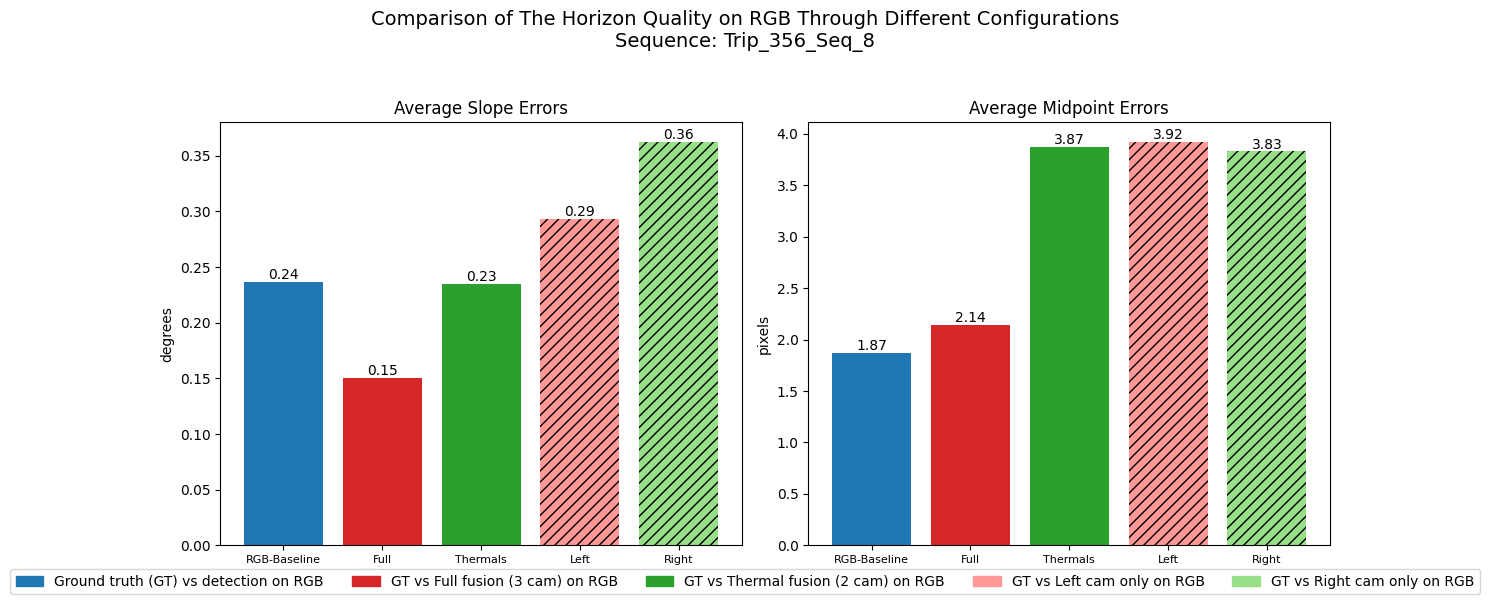

{'output_rgb_default': {'average_slope_error': 1.966929234406805, 'average_midpoint_error': 0.17753859488439674, 'average_midpoint_error_px': 5.548081090137398, 'stddev_slope_error': 0.4194481190382645, 'stddev_midpoint_error': 0.060350846815613424, 'stddev_midpoint_error_px': 1.8859639629879195, 'max_slope_error': 3.0052693596899336, 'max_midpoint_error': 0.3561142857142812, 'max_midpoint_error_px': 11.128571428571288, 'num_slope_error_jumps': 19, 'num_midpoint_error_jumps': 9, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 1.9904180087689527, 'average_midpoint_error': 0.03793330314899223, 'average_midpoint_error_px': 1.185415723406007, 'stddev_slope_error': 0.27800824050046447, 'stddev_midpoint_error': 0.025962433858467915, 'stddev_midpoint_error_px': 0.8113260580771223, 'max_slope_error': 2.448199767949297, 'max_midpoint_error': 0.11404157212429596, 'max_midpoint_error_px': 3.5637991288842485, 'num_slope_error_jumps': 8, 'num_midpoint_error_jumps': 0, 'detectio

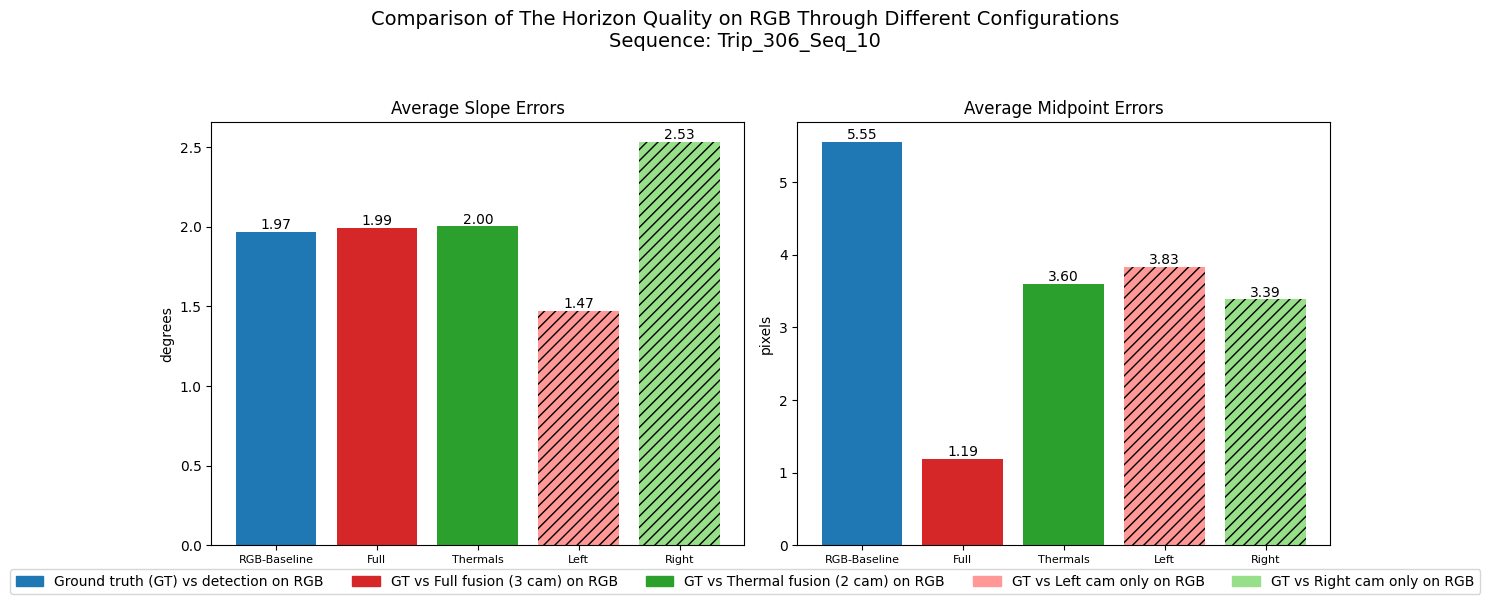

{'output_rgb_default': {'average_slope_error': 5.473479648155657, 'average_midpoint_error': 4.891944873949581, 'average_midpoint_error_px': 152.87327731092438, 'stddev_slope_error': 4.593677670368868, 'stddev_midpoint_error': 1.51989242231169, 'stddev_midpoint_error_px': 47.496638197240316, 'max_slope_error': 19.56040962344565, 'max_midpoint_error': 7.984457142857147, 'max_midpoint_error_px': 249.51428571428585, 'num_slope_error_jumps': 129, 'num_midpoint_error_jumps': 141, 'detection_rate': 1.1235294117647059}, 'fused_horizon_all': {'average_slope_error': 0.8293446489860115, 'average_midpoint_error': 1.6571596354527427, 'average_midpoint_error_px': 51.786238607898206, 'stddev_slope_error': 0.8136477076124952, 'stddev_midpoint_error': 0.6263465532647285, 'stddev_midpoint_error_px': 19.573329789522766, 'max_slope_error': 4.89025604421243, 'max_midpoint_error': 2.7234664528061003, 'max_midpoint_error_px': 85.10832665019063, 'num_slope_error_jumps': 81, 'num_midpoint_error_jumps': 95, 'de

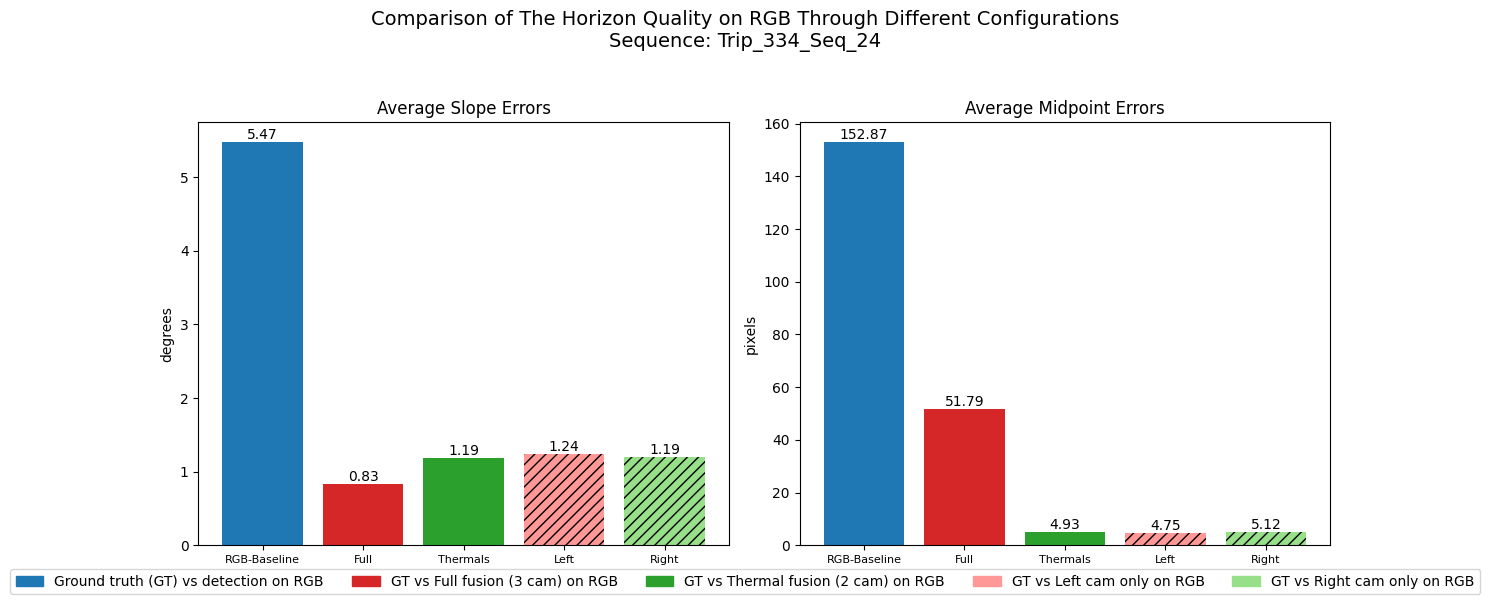

{'output_rgb_default': {'average_slope_error': 1.8335063502438338, 'average_midpoint_error': 0.14256137607505776, 'average_midpoint_error_px': 4.455043002345555, 'stddev_slope_error': 0.3770447996245432, 'stddev_midpoint_error': 0.05064648556245911, 'stddev_midpoint_error_px': 1.5827026738268473, 'max_slope_error': 2.9338418570249214, 'max_midpoint_error': 0.26011428571428613, 'max_midpoint_error_px': 8.12857142857144, 'num_slope_error_jumps': 38, 'num_midpoint_error_jumps': 18, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 1.9562559759748543, 'average_midpoint_error': 0.041425783684490375, 'average_midpoint_error_px': 1.2945557401403243, 'stddev_slope_error': 0.24302068031822116, 'stddev_midpoint_error': 0.028491815670016497, 'stddev_midpoint_error_px': 0.8903692396880155, 'max_slope_error': 2.7754966923858433, 'max_midpoint_error': 0.14218742876426946, 'max_midpoint_error_px': 4.44335714888342, 'num_slope_error_jumps': 10, 'num_midpoint_error_jumps': 2, 'detect

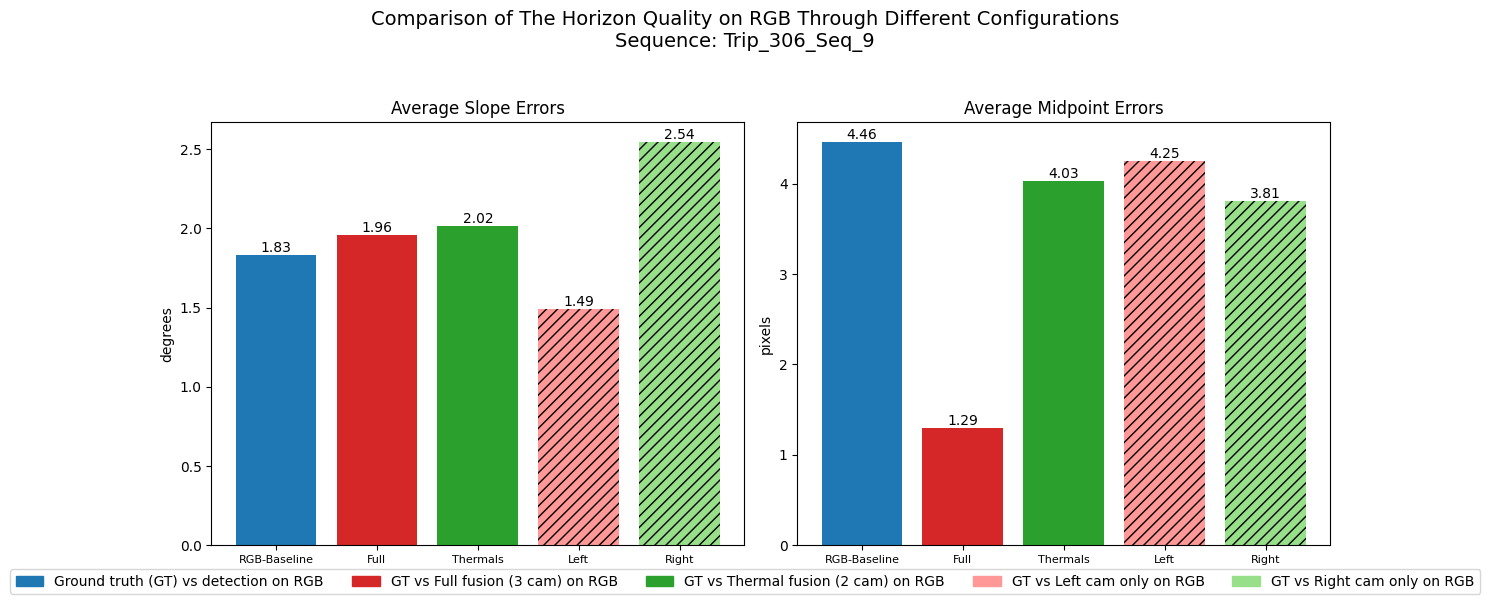

{'output_rgb_default': {'average_slope_error': 2.4733258535434457, 'average_midpoint_error': 0.4880060468631917, 'average_midpoint_error_px': 20.587755102040898, 'stddev_slope_error': 0.3048228574633724, 'stddev_midpoint_error': 0.07361592420511864, 'stddev_midpoint_error_px': 3.105671802403443, 'max_slope_error': 3.126939010664522, 'max_midpoint_error': 0.6653968253968245, 'max_midpoint_error_px': 28.07142857142853, 'num_slope_error_jumps': 29, 'num_midpoint_error_jumps': 21, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 1.7290643506109762, 'average_midpoint_error': 1.139335487580077, 'average_midpoint_error_px': 48.06571588228449, 'stddev_slope_error': 0.29617837836836325, 'stddev_midpoint_error': 0.05208450528943675, 'stddev_midpoint_error_px': 2.1973150668981125, 'max_slope_error': 2.4716933480193157, 'max_midpoint_error': 1.2683846697107939, 'max_midpoint_error_px': 53.509978253424116, 'num_slope_error_jumps': 12, 'num_midpoint_error_jumps': 10, 'detection_r

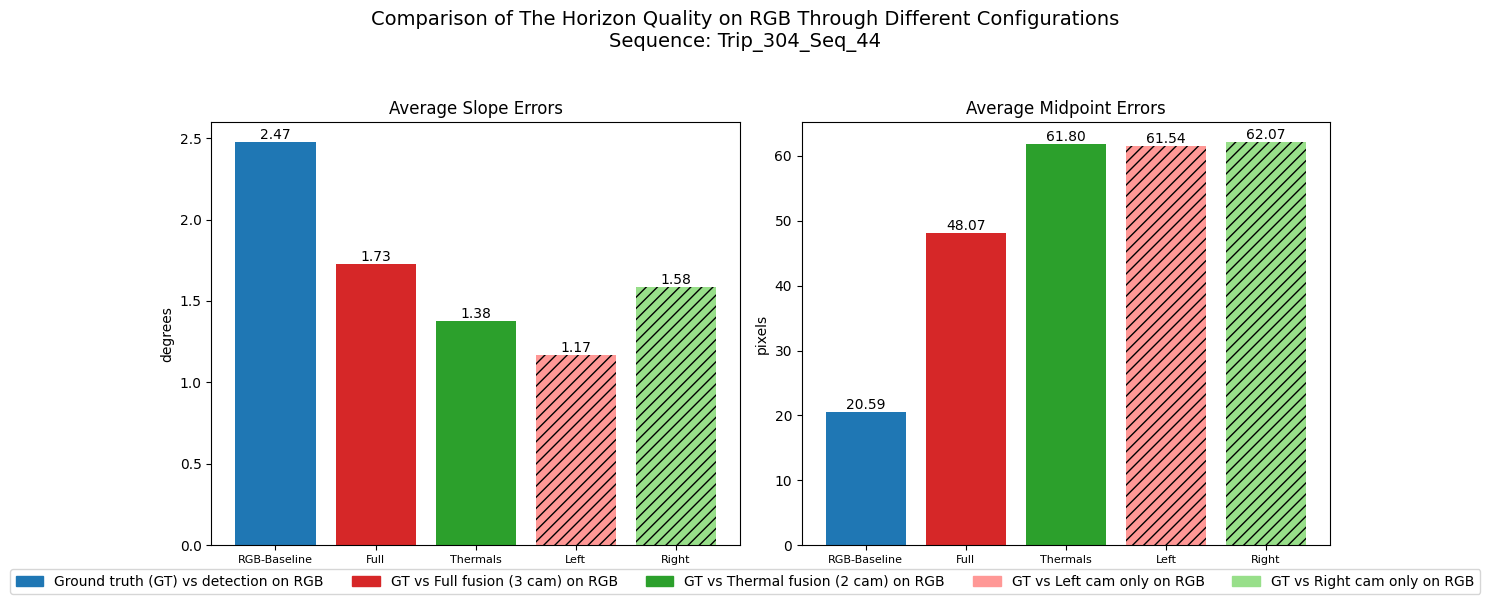

{'output_rgb_default': {'average_slope_error': 2.1926828852571125, 'average_midpoint_error': 0.16091073642047338, 'average_midpoint_error_px': 5.028460513139793, 'stddev_slope_error': 0.4420640937173383, 'stddev_midpoint_error': 0.19736449172487627, 'stddev_midpoint_error_px': 6.167640366402384, 'max_slope_error': 3.3592229437049865, 'max_midpoint_error': 1.8979224361845042, 'max_midpoint_error_px': 59.31007613076575, 'num_slope_error_jumps': 64, 'num_midpoint_error_jumps': 39, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 2.102072980928388, 'average_midpoint_error': 0.07751919970051681, 'average_midpoint_error_px': 2.4224749906411502, 'stddev_slope_error': 0.37254717869492515, 'stddev_midpoint_error': 0.08261589325277197, 'stddev_midpoint_error_px': 2.581746664149124, 'max_slope_error': 3.017829170358181, 'max_midpoint_error': 0.7611278041908961, 'max_midpoint_error_px': 23.785243880965503, 'num_slope_error_jumps': 42, 'num_midpoint_error_jumps': 19, 'detection_

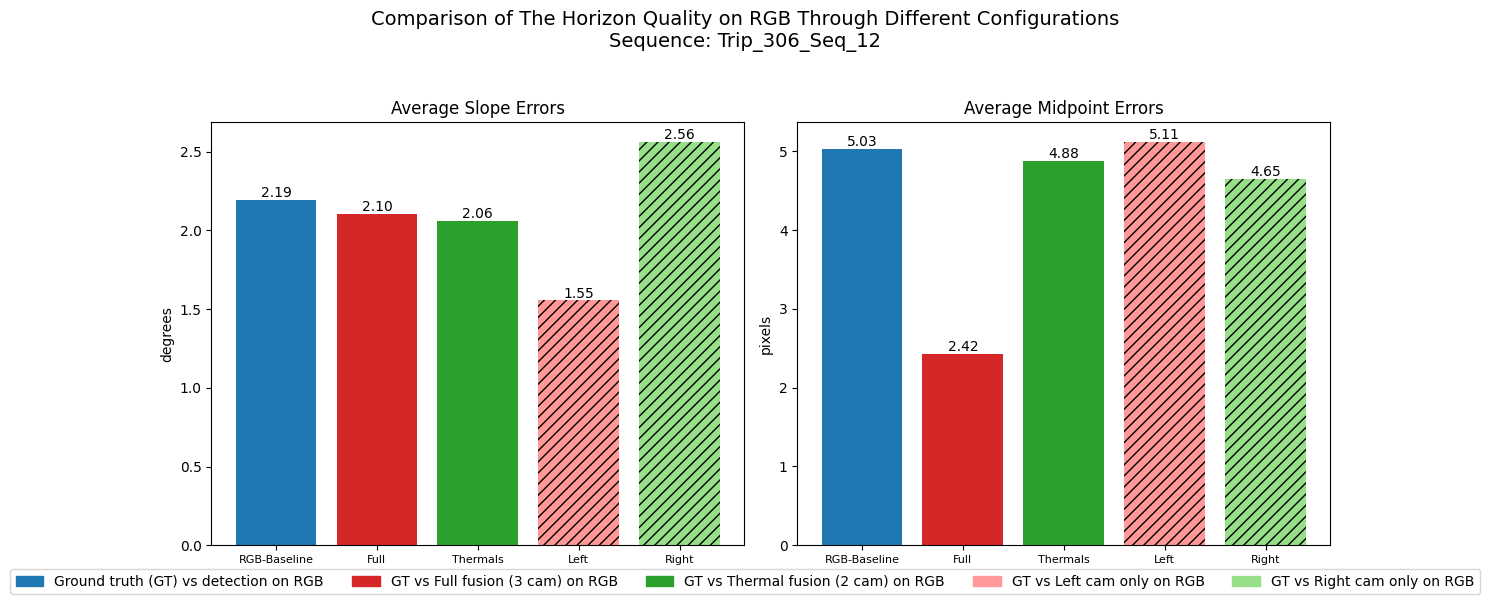

{'output_rgb_default': {'average_slope_error': 7.098517246288475, 'average_midpoint_error': 4.539123809523811, 'average_midpoint_error_px': 141.84761904761908, 'stddev_slope_error': 5.1268855251112795, 'stddev_midpoint_error': 1.1535889409806408, 'stddev_midpoint_error_px': 36.04965440564502, 'max_slope_error': 16.855824067730815, 'max_midpoint_error': 6.512000000000002, 'max_midpoint_error_px': 203.50000000000006, 'num_slope_error_jumps': 22, 'num_midpoint_error_jumps': 28, 'detection_rate': 4.766666666666667}, 'fused_horizon_all': {'average_slope_error': 0.6303162515955323, 'average_midpoint_error': 1.3707721345409707, 'average_midpoint_error_px': 42.83662920440533, 'stddev_slope_error': 0.45270782304148094, 'stddev_midpoint_error': 0.5152570435262641, 'stddev_midpoint_error_px': 16.10178261019575, 'max_slope_error': 1.808468455592091, 'max_midpoint_error': 2.171829695471061, 'max_midpoint_error_px': 67.86967798347065, 'num_slope_error_jumps': 13, 'num_midpoint_error_jumps': 22, 'det

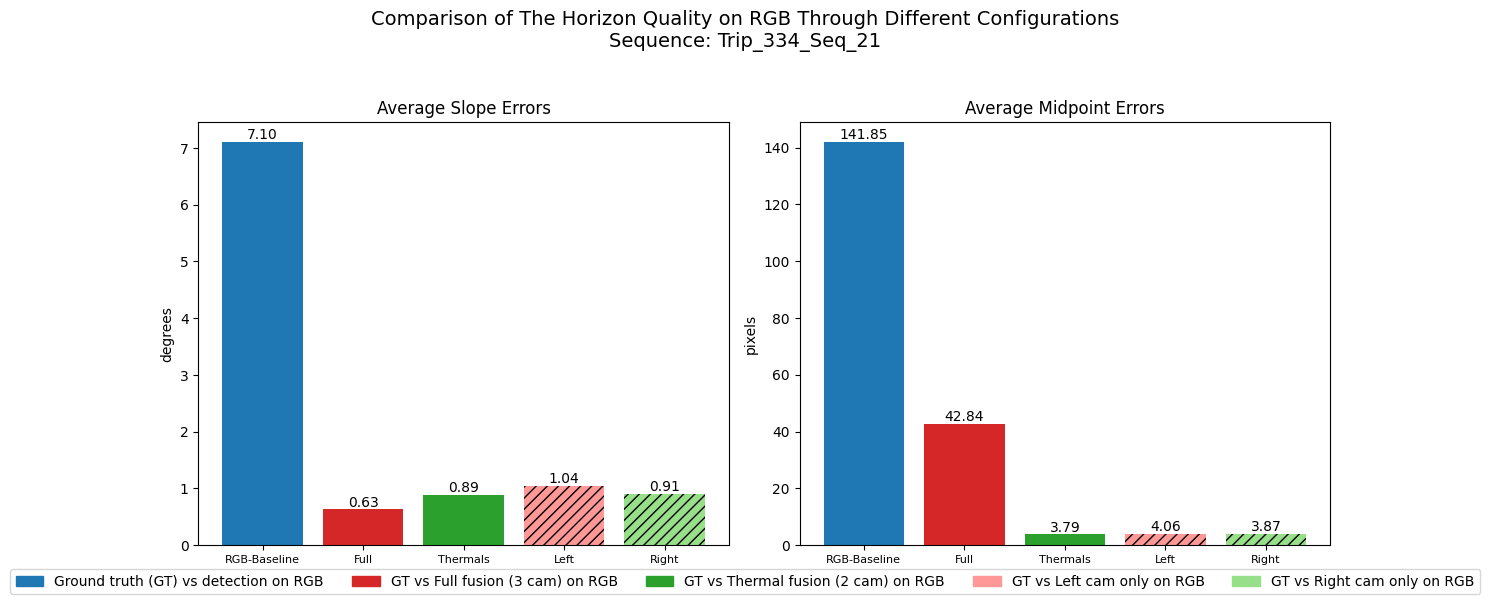

{'output_rgb_default': {'average_slope_error': 0.3461892814490194, 'average_midpoint_error': 0.11498556407053911, 'average_midpoint_error_px': 4.850953484225869, 'stddev_slope_error': 0.32495796035500085, 'stddev_midpoint_error': 0.05300854946099185, 'stddev_midpoint_error_px': 2.2362981803855937, 'max_slope_error': 1.1991615162638123, 'max_midpoint_error': 0.19283940991023485, 'max_midpoint_error_px': 8.135412605588034, 'num_slope_error_jumps': 2, 'num_midpoint_error_jumps': 3, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 1.2505691513069754, 'average_midpoint_error': 0.06467280912094793, 'average_midpoint_error_px': 2.728384134789991, 'stddev_slope_error': 0.25984562111701587, 'stddev_midpoint_error': 0.03579731456877633, 'stddev_midpoint_error_px': 1.5101992083702513, 'max_slope_error': 1.5234205566191032, 'max_midpoint_error': 0.11159341423057328, 'max_midpoint_error_px': 4.70784716285231, 'num_slope_error_jumps': 2, 'num_midpoint_error_jumps': 0, 'detection_

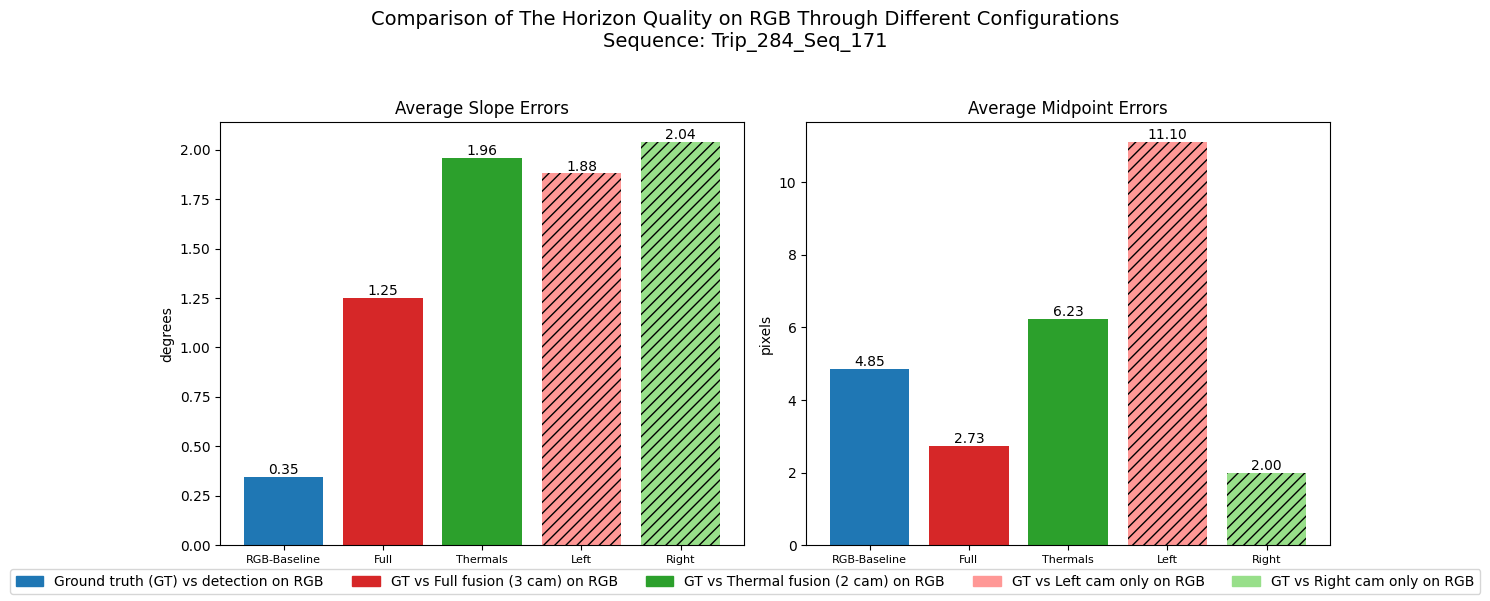

{'output_rgb_default': {'average_slope_error': 0.3794028315014104, 'average_midpoint_error': 0.06103287149160928, 'average_midpoint_error_px': 2.5748242660522664, 'stddev_slope_error': 0.2438001125701166, 'stddev_midpoint_error': 0.04574994630930861, 'stddev_midpoint_error_px': 1.930075859923957, 'max_slope_error': 0.8279174775079109, 'max_midpoint_error': 0.20859259259259205, 'max_midpoint_error_px': 8.799999999999976, 'num_slope_error_jumps': 4, 'num_midpoint_error_jumps': 2, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 1.3210352924284485, 'average_midpoint_error': 0.09463523220446765, 'average_midpoint_error_px': 3.992423858625979, 'stddev_slope_error': 0.15100591900171248, 'stddev_midpoint_error': 0.0329734859346779, 'stddev_midpoint_error_px': 1.3910689378692238, 'max_slope_error': 1.6097282193767077, 'max_midpoint_error': 0.16886639458795544, 'max_midpoint_error_px': 7.124051021679369, 'num_slope_error_jumps': 0, 'num_midpoint_error_jumps': 0, 'detection_r

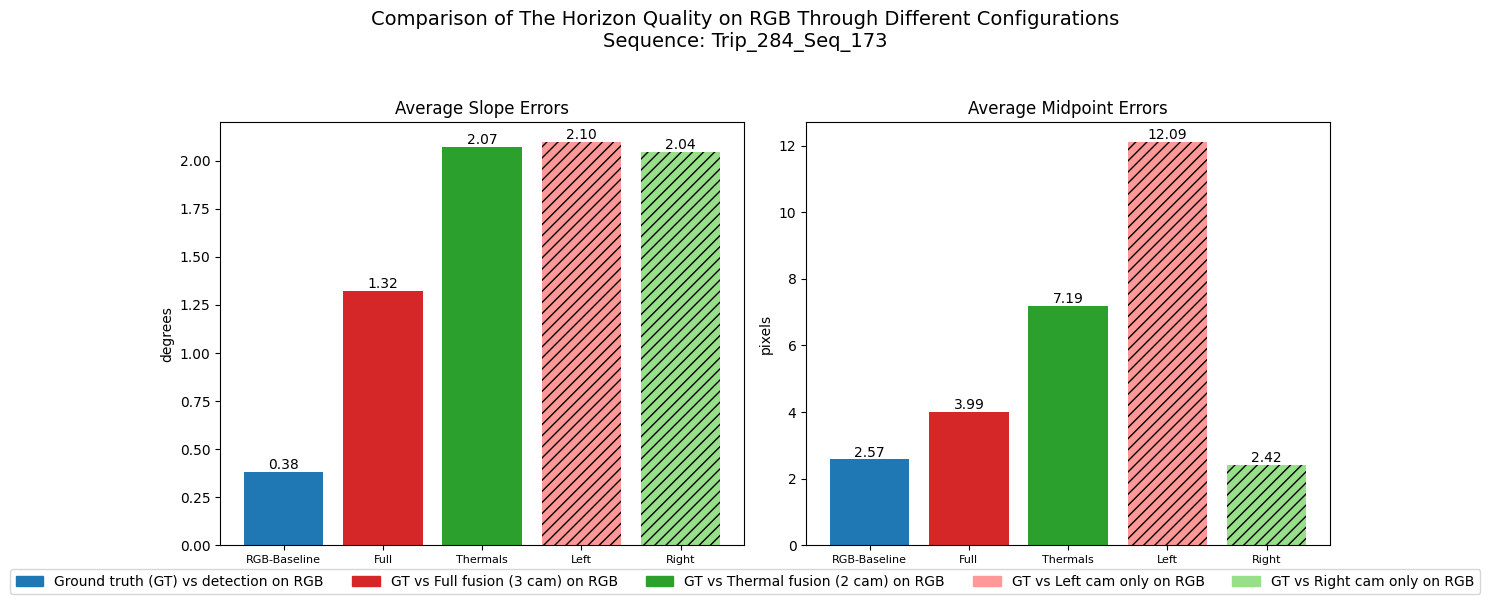

{'output_rgb_default': {'average_slope_error': 3.535081797075267, 'average_midpoint_error': 5.291794285714288, 'average_midpoint_error_px': 165.3685714285715, 'stddev_slope_error': 2.011225920912548, 'stddev_midpoint_error': 0.8520692765550102, 'stddev_midpoint_error_px': 26.62716489234407, 'max_slope_error': 7.877784120956387, 'max_midpoint_error': 6.472228571428572, 'max_midpoint_error_px': 202.25714285714287, 'num_slope_error_jumps': 8, 'num_midpoint_error_jumps': 9, 'detection_rate': 18.9}, 'fused_horizon_all': {'average_slope_error': 0.3619469532238529, 'average_midpoint_error': 1.972019346681801, 'average_midpoint_error_px': 61.62560458380628, 'stddev_slope_error': 0.20244389994075157, 'stddev_midpoint_error': 0.290347508065068, 'stddev_midpoint_error_px': 9.073359627033375, 'max_slope_error': 0.7284633037609924, 'max_midpoint_error': 2.1746625547857192, 'max_midpoint_error_px': 67.95820483705373, 'num_slope_error_jumps': 1, 'num_midpoint_error_jumps': 4, 'detection_rate': 1.0}, 

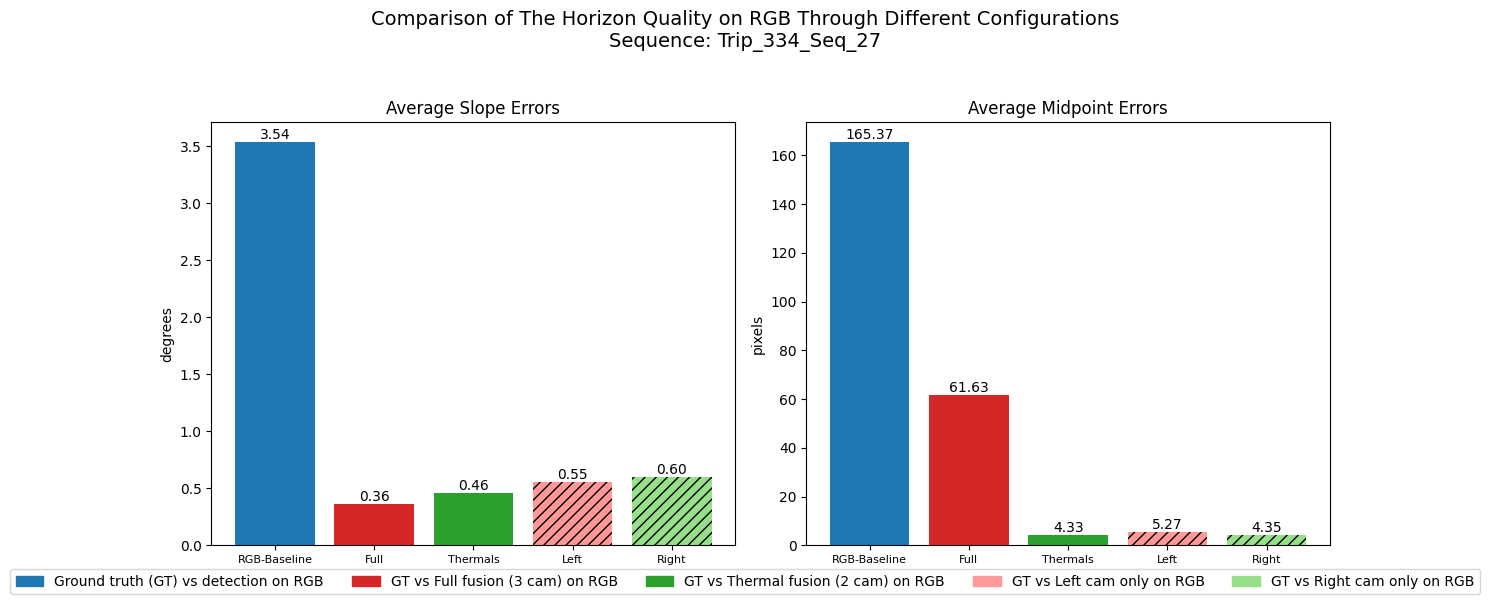

{'output_rgb_default': {'average_slope_error': 2.888072659569866, 'average_midpoint_error': 4.806057142857146, 'average_midpoint_error_px': 150.18928571428577, 'stddev_slope_error': 2.354803379764968, 'stddev_midpoint_error': 1.380699989283758, 'stddev_midpoint_error_px': 43.14687466511743, 'max_slope_error': 6.566261171567911, 'max_midpoint_error': 6.495085714285718, 'max_midpoint_error_px': 202.97142857142867, 'num_slope_error_jumps': 6, 'num_midpoint_error_jumps': 7, 'detection_rate': 1.125}, 'fused_horizon_all': {'average_slope_error': 1.003069928362494, 'average_midpoint_error': 1.418968032978263, 'average_midpoint_error_px': 44.34275103057072, 'stddev_slope_error': 0.7836004651803598, 'stddev_midpoint_error': 0.6476877648260393, 'stddev_midpoint_error_px': 20.240242650813727, 'max_slope_error': 2.5240705356730913, 'max_midpoint_error': 2.2994575569732647, 'max_midpoint_error_px': 71.85804865541452, 'num_slope_error_jumps': 4, 'num_midpoint_error_jumps': 6, 'detection_rate': 1.0},

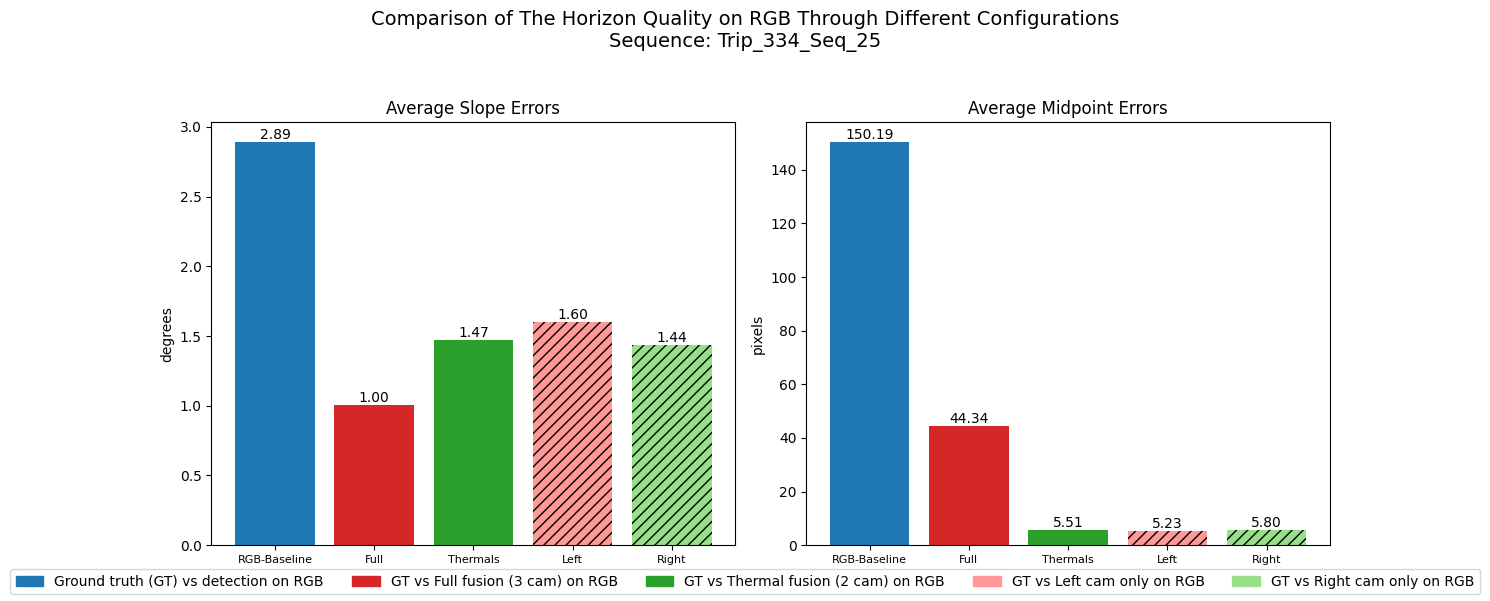

{'output_rgb_default': {'average_slope_error': 6.017186934341132, 'average_midpoint_error': 2.156799999999997, 'average_midpoint_error_px': 67.3999999999999, 'stddev_slope_error': 3.1631711934963866, 'stddev_midpoint_error': 0.2710857142857108, 'stddev_midpoint_error_px': 8.471428571428463, 'max_slope_error': 9.127783225763311, 'max_midpoint_error': 2.4278857142857078, 'max_midpoint_error_px': 75.87142857142837, 'num_slope_error_jumps': 1, 'num_midpoint_error_jumps': 1, 'detection_rate': 33.0}, 'fused_horizon_all': {'average_slope_error': 1.0583637176594203, 'average_midpoint_error': 1.3870552474793358, 'average_midpoint_error_px': 43.34547648372924, 'stddev_slope_error': 1.0369713843452961, 'stddev_midpoint_error': 0.8369330718773214, 'stddev_midpoint_error_px': 26.15415849616629, 'max_slope_error': 2.094635067142676, 'max_midpoint_error': 2.223988319356657, 'max_midpoint_error_px': 69.49963497989553, 'num_slope_error_jumps': 1, 'num_midpoint_error_jumps': 1, 'detection_rate': 1.0}, '

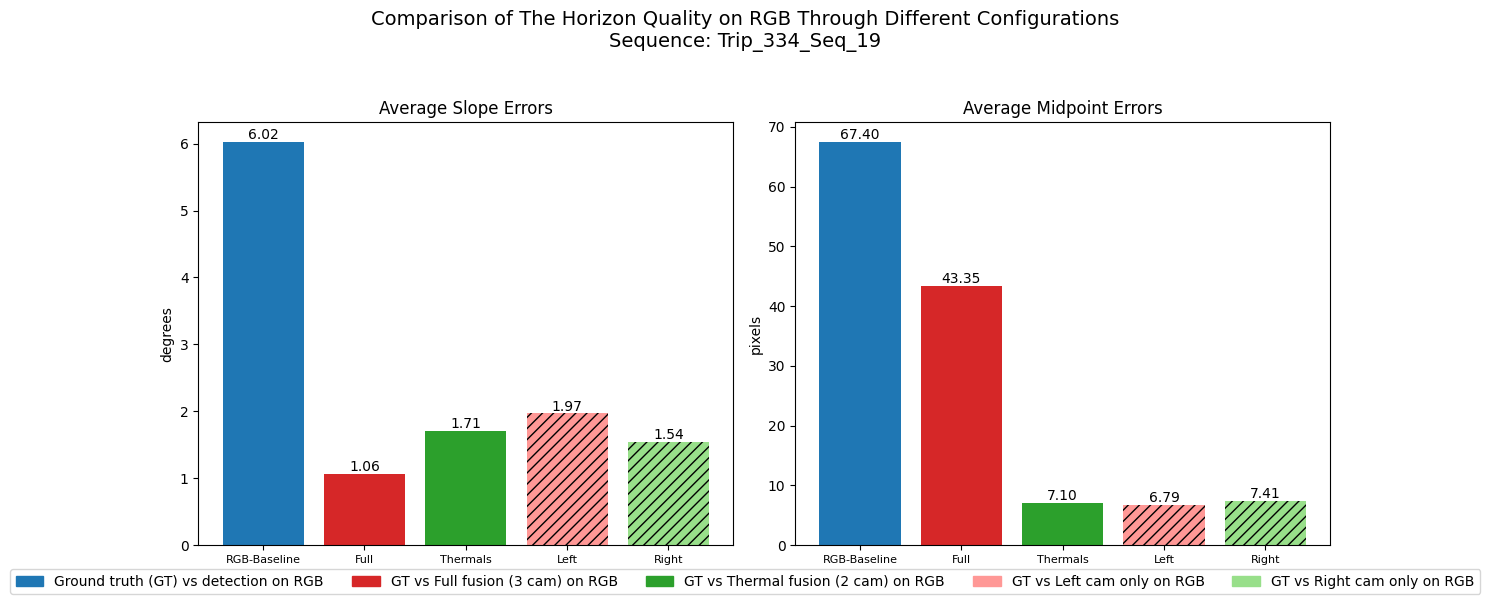

{'output_rgb_default': {'average_slope_error': 0.40749718100417476, 'average_midpoint_error': 0.9858829931972773, 'average_midpoint_error_px': 30.808843537414916, 'stddev_slope_error': 0.24253532915158643, 'stddev_midpoint_error': 1.133986796093612, 'stddev_midpoint_error_px': 35.43708737792537, 'max_slope_error': 0.8624213400056837, 'max_midpoint_error': 3.9977142857142853, 'max_midpoint_error_px': 124.92857142857142, 'num_slope_error_jumps': 4, 'num_midpoint_error_jumps': 12, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 1.2390983614298396, 'average_midpoint_error': 0.4226645986388313, 'average_midpoint_error_px': 13.208268707463478, 'stddev_slope_error': 1.0367561048085348, 'stddev_midpoint_error': 0.4185770208057251, 'stddev_midpoint_error_px': 13.08053190017891, 'max_slope_error': 4.860550649321696, 'max_midpoint_error': 1.3786908958037132, 'max_midpoint_error_px': 43.084090493866036, 'num_slope_error_jumps': 13, 'num_midpoint_error_jumps': 16, 'detection_ra

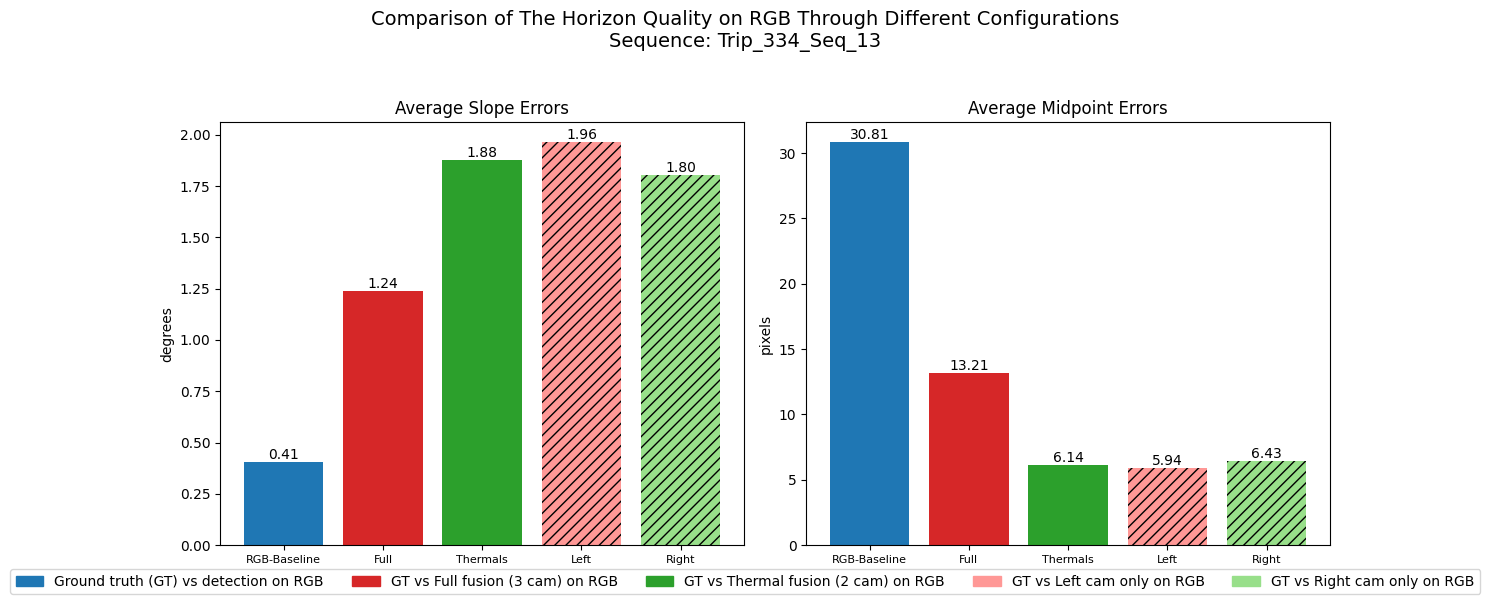

{'output_rgb_default': {'average_slope_error': 1.9832359482071866, 'average_midpoint_error': 0.12023708408042887, 'average_midpoint_error_px': 3.757408877513402, 'stddev_slope_error': 0.4642901784797233, 'stddev_midpoint_error': 0.16645542824899318, 'stddev_midpoint_error_px': 5.201732132781037, 'max_slope_error': 3.2894029459509393, 'max_midpoint_error': 1.9720384529398616, 'max_midpoint_error_px': 61.626201654370675, 'num_slope_error_jumps': 40, 'num_midpoint_error_jumps': 20, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 2.128797607721818, 'average_midpoint_error': 0.10899797535701435, 'average_midpoint_error_px': 3.406186729906698, 'stddev_slope_error': 0.41036286483485795, 'stddev_midpoint_error': 0.09577327820659247, 'stddev_midpoint_error_px': 2.9929149439560145, 'max_slope_error': 3.596155980031834, 'max_midpoint_error': 0.9301003858109141, 'max_midpoint_error_px': 29.065637056591065, 'num_slope_error_jumps': 18, 'num_midpoint_error_jumps': 12, 'detection

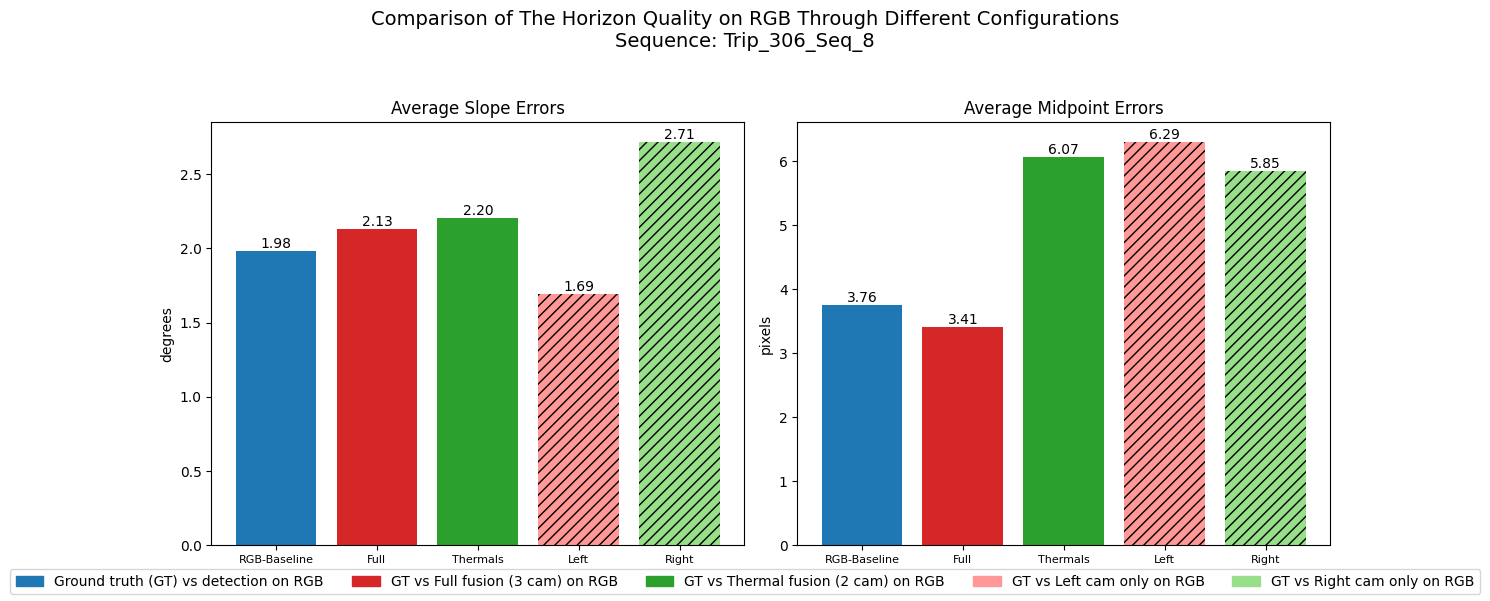

{'output_rgb_default': {'average_slope_error': 1.9988377454832438, 'average_midpoint_error': 0.18332608902356426, 'average_midpoint_error_px': 5.728940281986382, 'stddev_slope_error': 0.3755067156719829, 'stddev_midpoint_error': 0.21493755847218715, 'stddev_midpoint_error_px': 6.716798702255848, 'max_slope_error': 2.865970306979835, 'max_midpoint_error': 1.7134865467518936, 'max_midpoint_error_px': 53.54645458599667, 'num_slope_error_jumps': 10, 'num_midpoint_error_jumps': 7, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 1.9462105151149875, 'average_midpoint_error': 0.045873610680012084, 'average_midpoint_error_px': 1.4335503337503777, 'stddev_slope_error': 0.23693084882722448, 'stddev_midpoint_error': 0.08394547227728935, 'stddev_midpoint_error_px': 2.623296008665292, 'max_slope_error': 2.5731885939551984, 'max_midpoint_error': 0.6224330990287315, 'max_midpoint_error_px': 19.451034344647855, 'num_slope_error_jumps': 7, 'num_midpoint_error_jumps': 2, 'detection_r

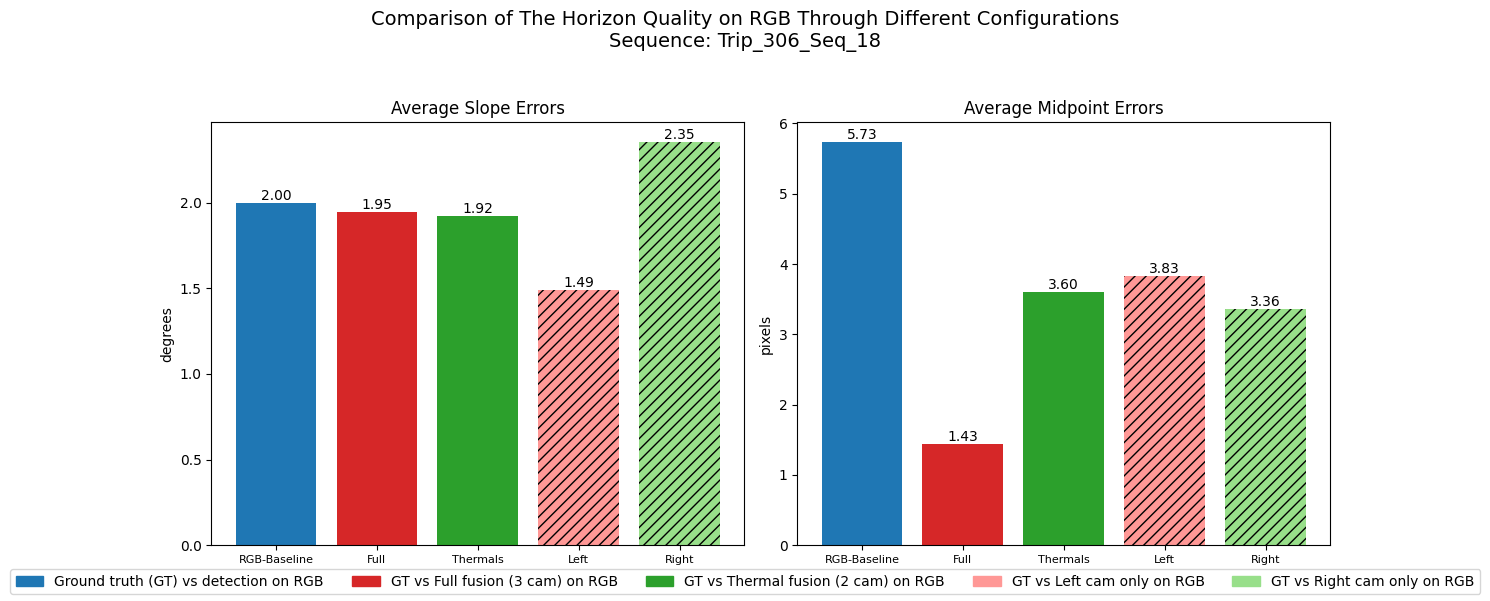

{'output_rgb_default': {'average_slope_error': 0.3645837366335206, 'average_midpoint_error': 0.05459434108717092, 'average_midpoint_error_px': 2.303198764615023, 'stddev_slope_error': 0.22663836055974576, 'stddev_midpoint_error': 0.04077818490271859, 'stddev_midpoint_error_px': 1.7203296755834403, 'max_slope_error': 0.7239451342114511, 'max_midpoint_error': 0.18488888888888938, 'max_midpoint_error_px': 7.80000000000002, 'num_slope_error_jumps': 2, 'num_midpoint_error_jumps': 2, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 1.3677222380147303, 'average_midpoint_error': 0.10513916876721359, 'average_midpoint_error_px': 4.435558682366823, 'stddev_slope_error': 0.1562844496538709, 'stddev_midpoint_error': 0.03322368415902175, 'stddev_midpoint_error_px': 1.40162417545873, 'max_slope_error': 1.7157421522837408, 'max_midpoint_error': 0.18071824643980677, 'max_midpoint_error_px': 7.624051021679348, 'num_slope_error_jumps': 0, 'num_midpoint_error_jumps': 0, 'detection_rat

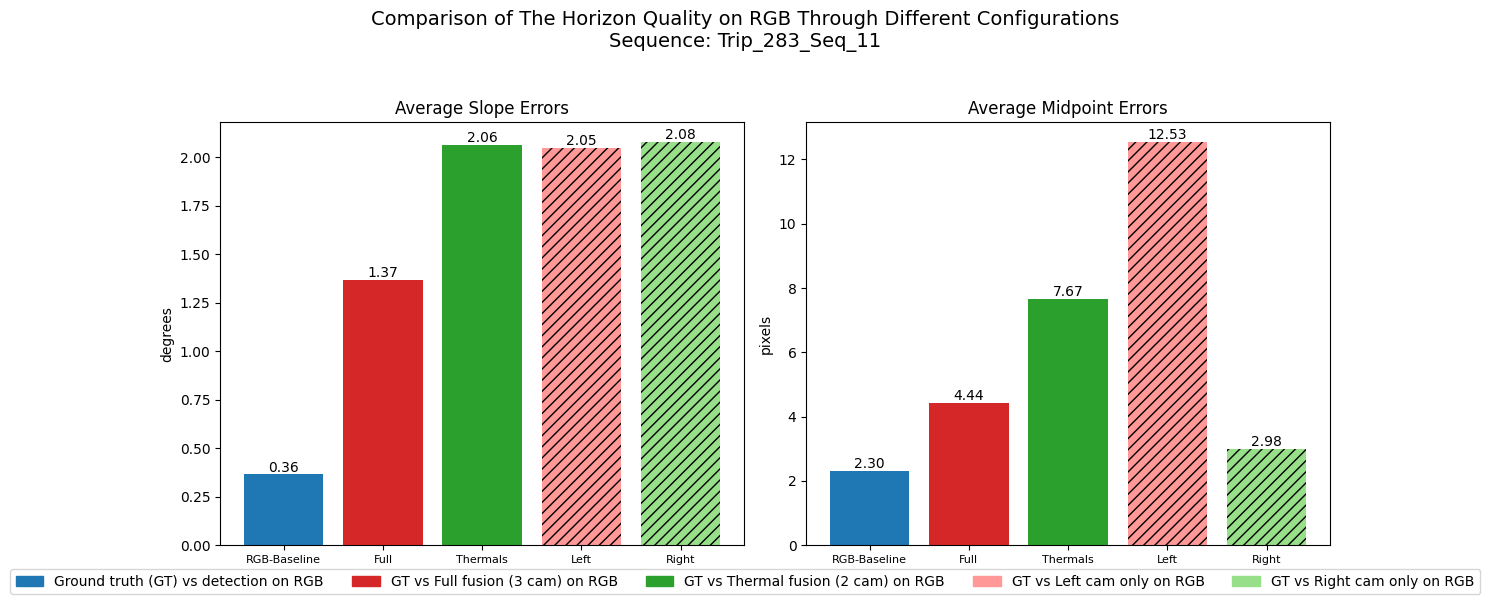

{'output_rgb_default': {'average_slope_error': 0.3571545374708598, 'average_midpoint_error': 0.052478547961597025, 'average_midpoint_error_px': 2.213938742129874, 'stddev_slope_error': 0.3183907761702882, 'stddev_midpoint_error': 0.04136895119749566, 'stddev_midpoint_error_px': 1.745252628644348, 'max_slope_error': 1.591140271194588, 'max_midpoint_error': 0.1943703703703676, 'max_midpoint_error_px': 8.199999999999882, 'num_slope_error_jumps': 13, 'num_midpoint_error_jumps': 6, 'detection_rate': 1.0}, 'fused_horizon_all': {'average_slope_error': 1.3519591236867756, 'average_midpoint_error': 0.10487568741269003, 'average_midpoint_error_px': 4.42444306272286, 'stddev_slope_error': 0.26136641813809736, 'stddev_midpoint_error': 0.03719153469874442, 'stddev_midpoint_error_px': 1.5690178701032802, 'max_slope_error': 1.8986581478329532, 'max_midpoint_error': 0.22327840463263726, 'max_midpoint_error_px': 9.419557695439384, 'num_slope_error_jumps': 9, 'num_midpoint_error_jumps': 6, 'detection_ra

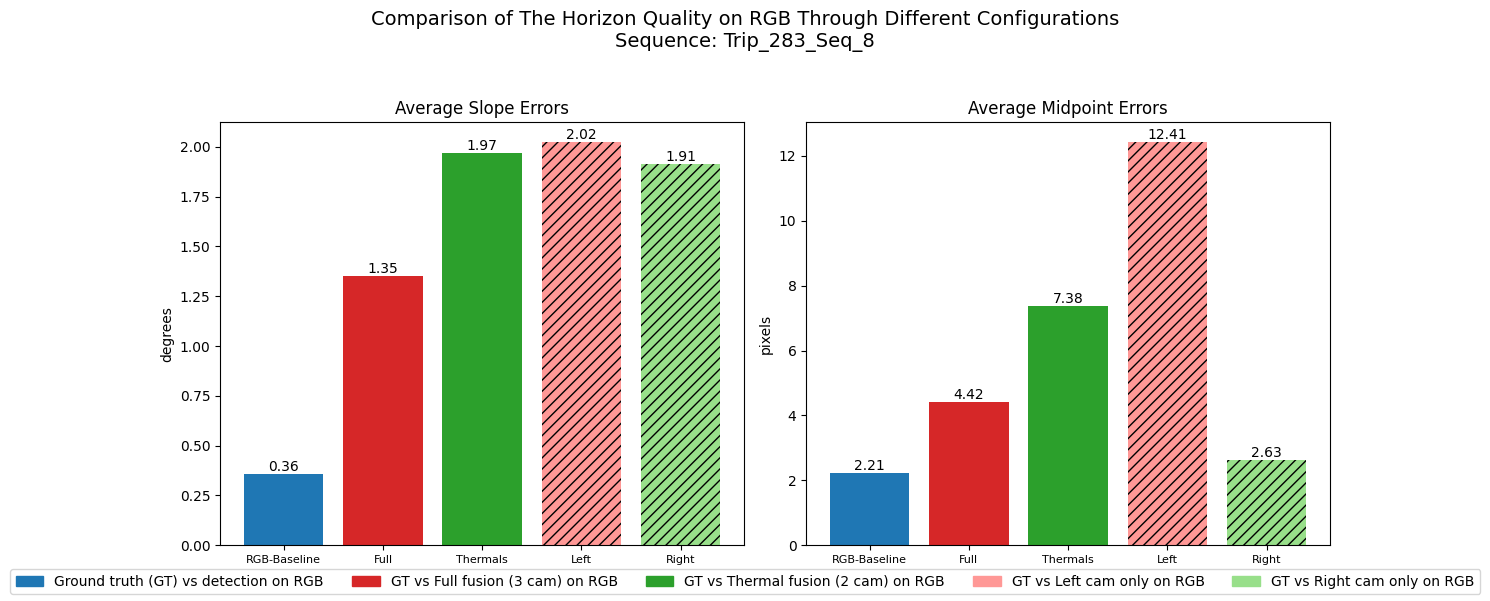

Processing and plotting complete.


In [167]:
import os
import pickle
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pprint
from tqdm import tqdm

# Define the directory containing the pickle files
stats_directory = './stats/'
figures_directory = './figures/'

# Create the figures directory if it does not exist
os.makedirs(figures_directory, exist_ok=True)

# Initialize a dictionary to store the loaded results
loaded_results = {}

# Iterate through the pickle files in the directory
for filename in os.listdir(stats_directory):
    if filename.endswith("_results.pkl"):
        sequence_name = filename.replace('_results.pkl', '')
        file_path = os.path.join(stats_directory, filename)
        
        # Load the pickle file
        with open(file_path, 'rb') as f:
            results = pickle.load(f)
        
        # Store the results in the dictionary
        loaded_results[sequence_name] = results
        
        # Extract data for plotting
        output_rgb_default = results.get('output_rgb_default', {})
        fused_horizon_all = results.get('fused_horizon_all', {})
        fused_horizon_thermal = results.get('fused_horizon_thermal', {})
        output_rgb_basic_l = results.get('output_rgb_basic_l', {})
        output_rgb_basic_r = results.get('output_rgb_basic_r', {})


        #print(results)

        output_rgb = output_rgb_default
        basic_l = fused_horizon_all
        basic_r = fused_horizon_thermal
        output_l = output_rgb_basic_l
        output_r = output_rgb_basic_r

        categories = ['RGB-Baseline', 'Full', 'Thermals', 'Left', 'Right']

        average_slope_errors = [output_rgb.get("average_slope_error", 0), basic_l.get("average_slope_error", 0), basic_r.get("average_slope_error", 0), output_l.get("average_slope_error", 0), output_r.get("average_slope_error", 0)]
        average_midpoint_errors = [output_rgb.get("average_midpoint_error_px", 0), basic_l.get("average_midpoint_error_px", 0), basic_r.get("average_midpoint_error_px", 0), output_l.get("average_midpoint_error_px", 0), output_r.get("average_midpoint_error_px", 0)]

        colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff9896', '#98df8a']
        hatches = ['', '', '', '///', '///']

        # Plotting
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Plot Average Slope Errors
        bars = ax[0].bar(categories, average_slope_errors, color=colors, hatch=hatches)
        ax[0].set_title('Average Slope Errors')
        ax[0].set_ylabel('degrees', fontsize=10)
        ax[0].bar_label(bars, fmt='%.2f')

        # Plot Average Midpoint Errors
        bars = ax[1].bar(categories, average_midpoint_errors, color=colors, hatch=hatches)
        ax[1].set_title('Average Midpoint Errors')
        ax[1].set_ylabel('pixels', fontsize=10)
        ax[1].bar_label(bars, fmt='%.2f')

        for axes in ax.flat:
            axes.tick_params(axis='x', labelsize=8)  # Adjust x-axis label font size

        # Add global title
        fig.suptitle(f'Comparison of The Horizon Quality on RGB Through Different Configurations\nSequence: {sequence_name}', fontsize=14)

        # Add legend at the bottom
        descriptions = ['Ground truth (GT) vs detection on RGB', 'GT vs Full fusion (3 cam) on RGB', 'GT vs Thermal fusion (2 cam) on RGB', 'GT vs Left cam only on RGB', 'GT vs Right cam only on RGB']
        legend_handles = [mpatches.Patch(color=colors[i], label=descriptions[i]) for i in range(len(descriptions))]
        fig.legend(handles=legend_handles, loc='lower center', ncol=len(descriptions), fontsize=10)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the global title and legend
        figure_path = os.path.join(figures_directory, f'{sequence_name}_comparison.png')
        #plt.savefig(figure_path, dpi=300, bbox_inches='tight')
        plt.show()
        #break

print("Processing and plotting complete.")